#### Topic: Understanding the Impact of Ozempic on Obese and Hypertensive Patients
##### Ji Hyun (Jenny) Kim

In [1]:
# Load Python Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import log_loss

from sklearn.linear_model import LassoCV
import statsmodels.api as sm

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold

In [2]:
# Import the dataset: Medical Claims Data
df_mc = pd.read_csv("longyear-obese-hypertensive-40-57-medical-SMALL-sample.csv", low_memory=False)
df_mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623525 entries, 0 to 623524
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         623525 non-null  object 
 1   episode_id         623525 non-null  object 
 2   visit_id           621650 non-null  object 
 3   encounter_id       623525 non-null  object 
 4   claim_date         623525 non-null  object 
 5   patient_state      623525 non-null  object 
 6   patient_short_zip  623512 non-null  float64
 7   patient_age        616980 non-null  float64
 8   patient_gender     623525 non-null  object 
 9   place_of_service   484555 non-null  object 
 10  visit_type         600454 non-null  object 
 11  payor              608936 non-null  object 
 12  payor_channel      586086 non-null  object 
 13  ref_npi            297501 non-null  float64
 14  hcp_npi            434653 non-null  float64
 15  hcp_taxonomy       428209 non-null  object 
 16  hc

In [3]:
# Import the dataset: Prescription Data
df_p = pd.read_csv("longyear-obese-hypertensive-40-75-scripts-SMALL-sample.csv", low_memory=False)
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894623 entries, 0 to 894622
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   journey_id                     894623 non-null  object 
 1   cohort_id                      894623 non-null  int64  
 2   claim_id                       894623 non-null  object 
 3   patient_gender                 894623 non-null  object 
 4   patient_state                  894623 non-null  object 
 5   patient_zip                    894623 non-null  object 
 6   patient_dob                    894623 non-null  object 
 7   pharmacy_npi                   894623 non-null  object 
 8   pharmacist_npi                 894623 non-null  object 
 9   prescriber_npi                 894623 non-null  object 
 10  primary_care_npi               894623 non-null  object 
 11  group_id                       894623 non-null  object 
 12  date_of_service               

In [4]:
df_mc.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
0,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
1,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
2,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3074F,NaN,1.0,0.00,0.00,46.57
3,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3078F,NaN,1.0,0.00,0.00,56.38
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,NaN,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16


In [5]:
df_p.head()

,journey_id,cohort_id,claim_id,patient_gender,patient_state,patient_zip,patient_dob,pharmacy_npi,pharmacist_npi,prescriber_npi,...,bin,plan_pay,reject_code_1,reject_code_3,reject_code_4,reject_code_5,ndc,active,start_date,end_date
0,00006390c96ebfffed580074c35a16a7,16,60618bd8d37311da702bf9349e76f8c26d515c082e136f...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
1,00006390c96ebfffed580074c35a16a7,16,dbeb47defd161331e43f4e359e8d43e4ef7546ff58359b...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
2,00006390c96ebfffed580074c35a16a7,16,02927d081fad10afffcba79bad27f94ff52c98e968aaec...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
3,00006390c96ebfffed580074c35a16a7,16,a412c986e2503a5140ed1482e88b5ec50feeedaf2d89ec...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
4,00006390c96ebfffed580074c35a16a7,16,b65634edd78998753fe9606b142b2fff7765d6c576973c...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,65862059805,True,190001,None


#### **1. Data Manipulation & Exploratory Data Analysis (EDA)**

In [6]:
# Check how many missing values are included
missing_values_count = df_mc.isnull().sum()
total_rows = len(df_mc)
(missing_values_count / total_rows)

journey_id           0.000000
episode_id           0.000000
visit_id             0.003007
encounter_id         0.000000
claim_date           0.000000
patient_state        0.000000
patient_short_zip    0.000021
patient_age          0.010497
patient_gender       0.000000
place_of_service     0.222878
visit_type           0.037001
payor                0.023398
payor_channel        0.060044
ref_npi              0.522872
hcp_npi              0.302910
hcp_taxonomy         0.313245
hcp_specialty        0.313213
hco_npi              0.009199
hcp_npi_list         0.302910
hco_npi_list         0.009199
diag_list            0.001395
diag_1               0.001395
diag_2               0.261305
diag_3               0.414163
diag_4               0.521698
diag_5               0.671198
rev_center_code      0.817287
rev_center_units     0.003155
proc_code            0.038351
proc_modifier        0.733855
proc_units           0.003519
line_charge          0.000000
claim_charge         0.000000
smart_allo

Some of the features has very large amount of missing values. Depending on the importance of the feature we should impute them before fitting the model.

In [7]:
# Check how many missing values are included
missing_values_count = df_p.isnull().sum()
total_rows = len(df_p)
(missing_values_count / total_rows)

journey_id                       0.000000
cohort_id                        0.000000
claim_id                         0.000000
patient_gender                   0.000000
patient_state                    0.000000
patient_zip                      0.000000
patient_dob                      0.000000
pharmacy_npi                     0.000000
pharmacist_npi                   0.000000
prescriber_npi                   0.000000
primary_care_npi                 0.000000
group_id                         0.000000
date_of_service                  0.000000
date_authorized                  0.000000
transaction_type                 0.000000
date_prescription_written        0.000000
ndc11                            0.000000
ndc11_original                   0.000000
number_of_refills_authorized     0.050417
diagnosis_code                   0.090036
diagnosis_code_type              0.000000
quantity_prescribed_original     0.639683
quantity_dispensed               0.000008
place_of_service                 0

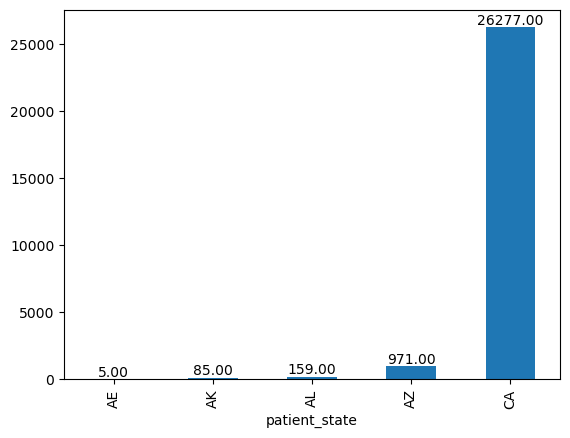

In [8]:
# Check the number of patients' states
patient_state_cnt = df_mc.groupby('patient_state')['journey_id'].nunique()

# plot a bar plot
patient_state_cnt .plot.bar()
for i, v in enumerate(patient_state_cnt):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

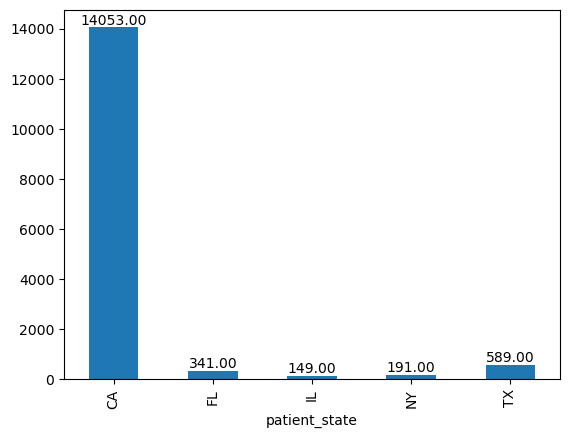

In [9]:
# Check the number of patients' states
patient_state_cnt2 = df_p.groupby('patient_state')['journey_id'].nunique()

# plot a bar plot
patient_state_cnt2 .plot.bar()
for i, v in enumerate(patient_state_cnt2):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

Both in the medical claim data and prescription data, most of patients are residing in California. While in medical claim data, there are AE, AK, AL, AZ but in prescription data, there are FL, IL, NY and TX. This means that if we try to join prescrption data for creating a feature for treatment, only data for patients in California will be useful. Thus, we decided to use data for California only for this analysis.

In [10]:
# Check top 10 OCC for Ozempic prescripted patients(use shortened code with the first 3 letters in codes)
# Merge two datasets(Medical claim containging diagnosis data and Ozempic prescribed patients data)
# Here we don't consider any duplications as this is just a procedure for having an idea on how to manipulate the dataset.

# Extract data of Ozempic prescribed data using NDC code
ozempic_ndcs = [169413001, 169413013, 169413211, 169413212, 169413290, 169413297, 169413602, 169413611, 169418103, 169418113, 169418190, 169418197, 169477211, 169477212, 169477290, 169477297]
df_oz = df_p[df_p['ndc'].isin(ozempic_ndcs)]

df_oz_merge =pd.merge(df_mc,df_oz,on='journey_id',how='inner')

# 1. Select 'diag_' columns
diag_columns = [col for col in df_oz_merge.columns if col.startswith('diag_')]
df_diag = df_oz_merge[diag_columns]

# 2. Combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# 3. Process first three digits (same as before)
first_three_counts = {}
for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_counts[first_three] = first_three_counts.get(first_three, 0) + 1

import operator
# Sort the dictionary items by count (descending order)
sorted_counts = sorted(first_three_counts.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)

('E11', 191294)
('I10', 88724)
('E78', 62485)
('Z00', 35659)
('E66', 25573)
('M54', 24468)
('M25', 23966)
('Z79', 22818)
('Z68', 20904)
('G47', 17321)
('N18', 16403)
('M79', 14262)
('Z12', 13579)
('E55', 12445)
('Z01', 12061)
('E03', 11308)
('I25', 11133)
('Z71', 11054)
('R07', 10410)
('R10', 10372)
('Z13', 9306)
('R53', 8906)
('M17', 8846)
('H25', 8582)
('R06', 8178)
('D64', 6956)
('N39', 6934)
('Z20', 6514)
('I50', 6424)
('E87', 6376)
('R73', 5871)
('I12', 5735)
('K21', 5717)
('E53', 5421)
('K76', 5370)
('M99', 5060)
('B35', 4975)
('M47', 4793)
('F41', 4773)
('I11', 4750)
('F33', 4679)
('G89', 4344)
('R79', 4329)
('Z23', 4290)
('H40', 4260)
('N17', 4237)
('M51', 4190)
('I48', 4076)
('Z11', 4051)
('D50', 4026)
('N40', 3991)
('U07', 3944)
('R33', 3805)
('R94', 3579)
('M19', 3513)
('J45', 3472)
('I13', 3382)
('Z99', 3355)
('Z86', 3239)
('K43', 3126)
('Z85', 3088)
('H52', 2991)
('H35', 2985)
('E34', 2886)
('N20', 2868)
('M48', 2837)
('Z98', 2828)
('R00', 2802)
('J30', 2754)
('Z76', 2722)

Top 5 OCC for Ozempic 

- `E11`  Type 2 diabetes mellitus without complications.
- `I10`  Essential (primary) hypertension.
- `E78`  Disorders of lipoprotein metabolism and other lipidemias
- `Z00`  Encounter for general adult medical examination without abnormal findings
- `E66`  Overweight and obesity

Originally, Ozempic is used for treating Type 2 diabetes and losing weight is one of side effect of this medication. Thus, it's not surprising that majority of patients who have received Ozempic are suffering from Type 2 diabetes. 

Before move forward, organize dataset using known information:
1. The objective of this analysis is to understand the effectiveness of Ozempic on "Obese and Hypertensive" patients, Thus we need to filter those patients who were diagnosed these diseases primarily in the medical claim data using ICD 10CM codes. And we will divide these into two datasets, one for Obesity and the other for Hypertension, to fit models separately.
2. Due to the objective of study stated in #1, we also need to use prescription data only for Ozempic code using NDC codes.
3. Also since we've observed that California is dominant in the dataset and no other states are overlapped between two datasets, we will use data of patients in California, for both datasets.
4. According to the Google Trend data, interest in Ozempic started to rise from 2022-01. Thus, we should filter the medical claim as well as prescription data starting from 2022.
5. Filter out patients whose age is not between 40 and 75.

In [11]:
# ICD 10CM codes
# Obesity code = E66
# Hypertention code = I10
# Medical claim data with patients diagnosed obesity or hypertention for the first diagnosis

# Filter rows where 'diag_1' is not null
df_mc_non_null = df_mc[df_mc['diag_1'].notnull()]

# Then filter rows based on the start of 'diag_1'
df_mc2 = df_mc_non_null[df_mc_non_null['diag_1'].str.startswith(('E66', 'I10'))]

# Use California patients data only
df_mc2 = df_mc2[df_mc2['patient_state']=='CA']

# Exclude medical claim data beforw Jan 2022
df_mc2 = df_mc2[df_mc2['claim_date']>='2022-01-01']

# Age filter(40-75)
df_mc2 = df_mc2[(df_mc2['patient_age']>=40) & (df_mc2['patient_age']<76)]

df_mc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27041 entries, 91 to 623519
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   journey_id         27041 non-null  object 
 1   episode_id         27041 non-null  object 
 2   visit_id           27022 non-null  object 
 3   encounter_id       27041 non-null  object 
 4   claim_date         27041 non-null  object 
 5   patient_state      27041 non-null  object 
 6   patient_short_zip  27041 non-null  float64
 7   patient_age        27041 non-null  float64
 8   patient_gender     27041 non-null  object 
 9   place_of_service   22719 non-null  object 
 10  visit_type         25965 non-null  object 
 11  payor              25591 non-null  object 
 12  payor_channel      24829 non-null  object 
 13  ref_npi            12949 non-null  float64
 14  hcp_npi            18320 non-null  float64
 15  hcp_taxonomy       18180 non-null  object 
 16  hcp_specialty      1

In [12]:
# Ozempic NDC Code(s):
# 0169413001, 0169413013, 0169413211, 0169413212, 0169413290, 0169413297, 0169413602, 0169413611, 0169418103, 0169418113, 0169418190, 0169418197, 0169477211, 0169477212, 0169477290, 0169477297
#(source: https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=adec4fd2-6858-4c99-91d4-531f5f2a2d79)

# Prescription data with patients diagnosed obesity or hypertention at least once
ozempic_ndcs = [169413001, 169413013, 169413211, 169413212, 169413290, 169413297, 169413602, 169413611, 169418103, 169418113, 169418190, 169418197, 169477211, 169477212, 169477290, 169477297]
df_p2 = df_p[df_p['ndc'].isin(ozempic_ndcs)]

# Use California patients data only
df_p2 = df_p2[df_p2['patient_state']=='CA']

# Exclude prescription data beforw Jan 2022
df_p2 = df_p2[df_p2['date_of_service']>='2022-01-01']

df_p2.info() # 79549 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9959 entries, 500 to 894608
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   journey_id                     9959 non-null   object 
 1   cohort_id                      9959 non-null   int64  
 2   claim_id                       9959 non-null   object 
 3   patient_gender                 9959 non-null   object 
 4   patient_state                  9959 non-null   object 
 5   patient_zip                    9959 non-null   object 
 6   patient_dob                    9959 non-null   object 
 7   pharmacy_npi                   9959 non-null   object 
 8   pharmacist_npi                 9959 non-null   object 
 9   prescriber_npi                 9959 non-null   object 
 10  primary_care_npi               9959 non-null   object 
 11  group_id                       9959 non-null   object 
 12  date_of_service                9959 non-null

In [13]:
print(len(df_p2['journey_id']), df_p2['journey_id'].nunique())
# There are 9959 entries in the prescription data, but 951 unique patients. Thus, we need to create an aggregated dataset containing one patient per one row

9959 951


In [14]:
# Aggregate quantity and days supplied by each patient
df_p3=df_p2.groupby('journey_id')[['quantity_dispensed','days_supply']].sum().reset_index()
df_p3.head()
#df_p3.info()# 951 entries

,journey_id,quantity_dispensed,days_supply
0,0003ff8dd03803a9197ed01075f4b094,12.0,294.0
1,00056d978dce9b6f87ee68765b0f5cb2,13.5,196.0
2,000611c33bf684a7fec8eb5bf8ef2c80,25.5,462.0
3,000855c2162997662fbc10d1f00da5ba,12.0,112.0
4,000f40e84695544650e491b7585bd483,16.5,492.0


In [15]:
df_p3.isnull().sum()

journey_id            0
quantity_dispensed    0
days_supply           0
dtype: int64

In [16]:
# Now, join two datasets. Use left join and if the journey_id is not matched then the patients are not treated.
data_merge = pd.merge(df_mc2, df_p3, on=['journey_id'], how='left')
data_merge.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed,quantity_dispensed,days_supply
0,00025243850b83969606f3f2aafc2d99,67f4df54bf85e427589ed1cd425270f6,6b7c9e01419fcd1fba69c3f1a44b5d9e81967db789bf21...,2db3a06e836eb02dedad5f3982685cee7376282a619af5...,2022-07-21,CA,910.0,70.0,F,NaN,...,NaN,1.0,99213,95,1.0,175.00,175.00,0.00,NaN,NaN
1,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,NaN,1.0,3078F,NaN,1.0,0.01,0.01,56.38,NaN,NaN
2,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,NaN,1.0,1159F,NaN,1.0,0.01,0.01,44.68,NaN,NaN
3,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,NaN,1.0,3008F,NaN,1.0,0.01,0.01,48.46,NaN,NaN
4,0004bed2670fd243392dc3a994da3f8a,ddd181f11bb36a27b920c61df51ca642,9e73758d2163af00d8005682f202cd6f6d339e9a692d78...,39a76631c902efb924077e77aeda59f9af6b582444e5c0...,2022-08-29,CA,911.0,50.0,M,Independent Clinic,...,NaN,1.0,99204,NaN,1.0,0.00,0.00,129.72,NaN,NaN


In [17]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27041 entries, 0 to 27040
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   journey_id          27041 non-null  object 
 1   episode_id          27041 non-null  object 
 2   visit_id            27022 non-null  object 
 3   encounter_id        27041 non-null  object 
 4   claim_date          27041 non-null  object 
 5   patient_state       27041 non-null  object 
 6   patient_short_zip   27041 non-null  float64
 7   patient_age         27041 non-null  float64
 8   patient_gender      27041 non-null  object 
 9   place_of_service    22719 non-null  object 
 10  visit_type          25965 non-null  object 
 11  payor               25591 non-null  object 
 12  payor_channel       24829 non-null  object 
 13  ref_npi             12949 non-null  float64
 14  hcp_npi             18320 non-null  float64
 15  hcp_taxonomy        18180 non-null  object 
 16  hcp_

In [18]:
data_merge.isnull().sum() # check the number of missing values in the merged dataset

journey_id                0
episode_id                0
visit_id                 19
encounter_id              0
claim_date                0
patient_state             0
patient_short_zip         0
patient_age               0
patient_gender            0
place_of_service       4322
visit_type             1076
payor                  1450
payor_channel          2212
ref_npi               14092
hcp_npi                8721
hcp_taxonomy           8861
hcp_specialty          8861
hco_npi                 139
hcp_npi_list           8721
hco_npi_list            139
diag_list                 0
diag_1                    0
diag_2                 4074
diag_3                 7109
diag_4                10027
diag_5                15526
rev_center_code       23874
rev_center_units         19
proc_code               254
proc_modifier         23554
proc_units               26
line_charge               0
claim_charge              0
smart_allowed             0
quantity_dispensed    25945
days_supply         

In [19]:
# Fill NaNs in quantity_dispensed, days_supply with 0
data_merge['quantity_dispensed'] = data_merge['quantity_dispensed'].fillna(0)
data_merge['days_supply'] = data_merge['days_supply'].fillna(0)
data_merge.isnull().sum()

journey_id                0
episode_id                0
visit_id                 19
encounter_id              0
claim_date                0
patient_state             0
patient_short_zip         0
patient_age               0
patient_gender            0
place_of_service       4322
visit_type             1076
payor                  1450
payor_channel          2212
ref_npi               14092
hcp_npi                8721
hcp_taxonomy           8861
hcp_specialty          8861
hco_npi                 139
hcp_npi_list           8721
hco_npi_list            139
diag_list                 0
diag_1                    0
diag_2                 4074
diag_3                 7109
diag_4                10027
diag_5                15526
rev_center_code       23874
rev_center_units         19
proc_code               254
proc_modifier         23554
proc_units               26
line_charge               0
claim_charge              0
smart_allowed             0
quantity_dispensed        0
days_supply         

In [20]:
# set treatment column, if quantity_dispensed is greater than 0 then 1 else 0
data_merge['treatment'] = np.where(data_merge['quantity_dispensed'] > 0, 1, 0)
data_merge.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed,quantity_dispensed,days_supply,treatment
0,00025243850b83969606f3f2aafc2d99,67f4df54bf85e427589ed1cd425270f6,6b7c9e01419fcd1fba69c3f1a44b5d9e81967db789bf21...,2db3a06e836eb02dedad5f3982685cee7376282a619af5...,2022-07-21,CA,910.0,70.0,F,NaN,...,1.0,99213,95,1.0,175.00,175.00,0.00,0.0,0.0,0
1,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,1.0,3078F,NaN,1.0,0.01,0.01,56.38,0.0,0.0,0
2,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,1.0,1159F,NaN,1.0,0.01,0.01,44.68,0.0,0.0,0
3,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,1.0,3008F,NaN,1.0,0.01,0.01,48.46,0.0,0.0,0
4,0004bed2670fd243392dc3a994da3f8a,ddd181f11bb36a27b920c61df51ca642,9e73758d2163af00d8005682f202cd6f6d339e9a692d78...,39a76631c902efb924077e77aeda59f9af6b582444e5c0...,2022-08-29,CA,911.0,50.0,M,Independent Clinic,...,1.0,99204,NaN,1.0,0.00,0.00,129.72,0.0,0.0,0


##### Keep performing EDA

  patient_gender  treatment  count  gender_ratio
0              F          0   3790      0.580754
1              F          1    129      0.597222
2              M          0   2736      0.419246
3              M          1     87      0.402778


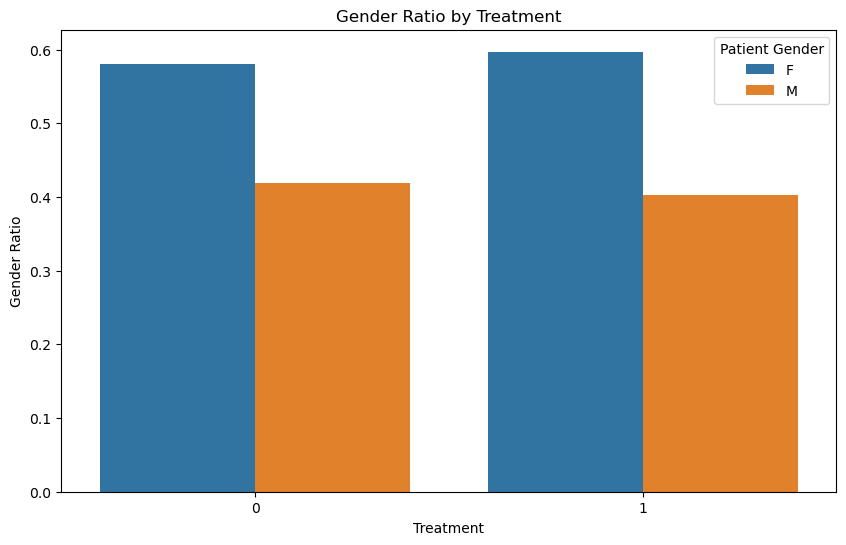

In [21]:
# Calculate the count of unique patient journeys by gender and treatment
patients_gender_cnt = data_merge.groupby(['patient_gender', 'treatment'])['journey_id'].nunique().reset_index(name='count')

# Total count of patients within each treatment
treatment_total_cnt = patients_gender_cnt.groupby('treatment')['count'].transform('sum')

# Calculate the gender ratio within each treatment category
patients_gender_cnt['gender_ratio'] = patients_gender_cnt['count'] / treatment_total_cnt

print(patients_gender_cnt)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='treatment', y='gender_ratio', hue='patient_gender', data=patients_gender_cnt)
plt.title('Gender Ratio by Treatment')
plt.ylabel('Gender Ratio')
plt.xlabel('Treatment')
plt.legend(title='Patient Gender')
plt.show()

There are more women than men among patients, both in treatment and control group. → It is not likely that a patient's gender affect treatment assignment

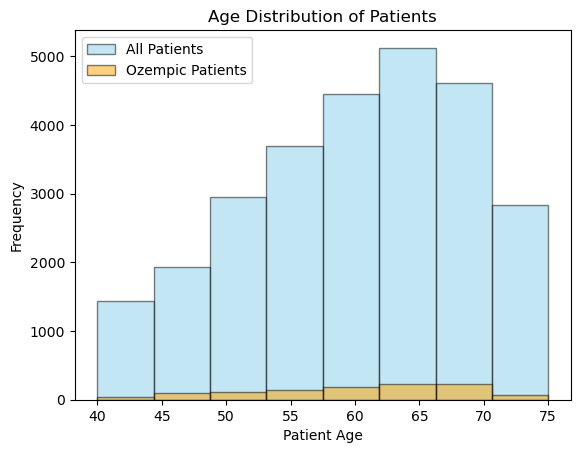

In [22]:
data_oz = data_merge[data_merge['treatment']==1]
all_patient_ages = data_merge['patient_age']
ozempic_patient_ages = data_oz['patient_age']

plt.hist(all_patient_ages, bins=8, color='skyblue', alpha=0.5, label='All Patients', edgecolor='black')
plt.hist(ozempic_patient_ages, bins=8, color='orange', alpha=0.5, label='Ozempic Patients', edgecolor='black')

plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients')
plt.legend()
plt.show()

Most of the patients are in their 60s and 70s. There's no distinctive difference observed between the distribution of patient age between all patients and Ozempic patients. 


/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_65650/317446619.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(patients_place_top5['place_of_service'], rotation=45, ha='right')


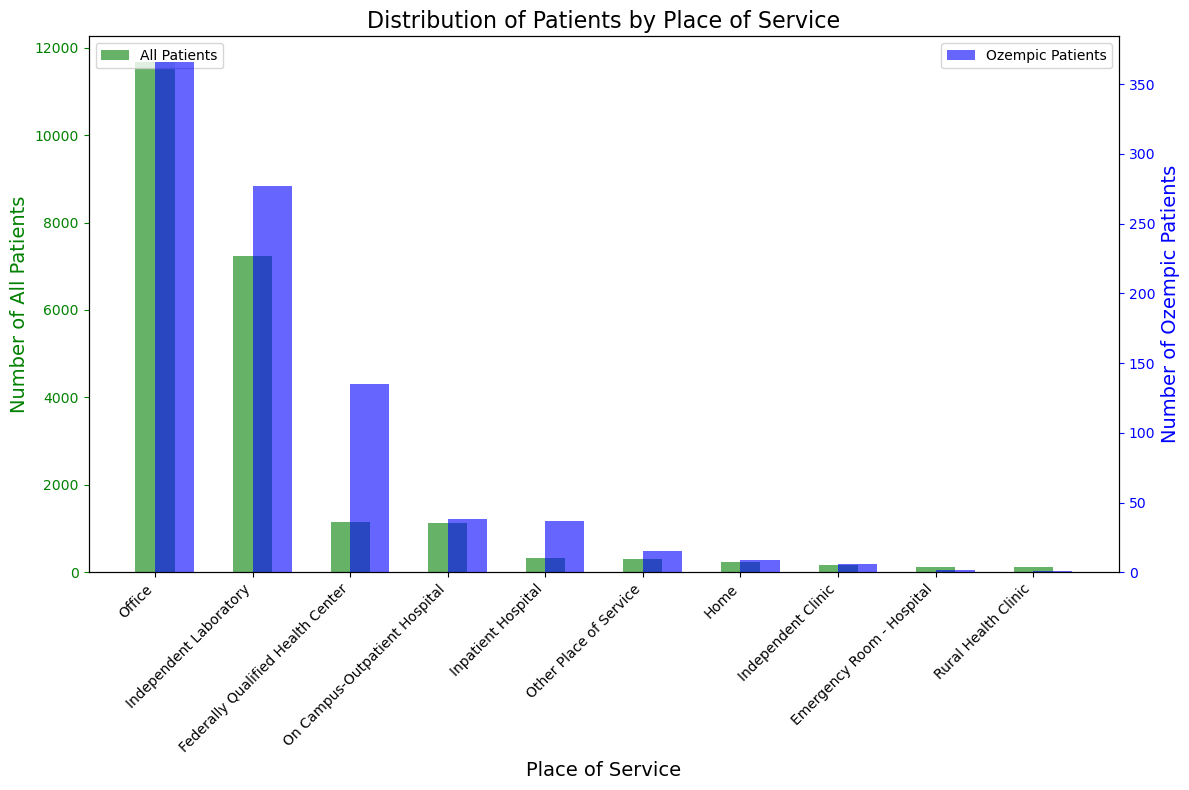

In [23]:
# Check the distribution of Obese/Hypertensive patients and Ozempic patients

# Create data of top 10 place of service for Obese/Hypertensive patients
patients_place = data_merge.groupby(['place_of_service'])['journey_id'].count().reset_index(name='count')
patients_place_sorted = patients_place.sort_values('count', ascending=False)
patients_place_top5 = patients_place_sorted.head(10)

# Create data of top 10 place of service for Obese/Hypertensive+prescribed Ozempic patients
data_oz = data_merge[data_merge['treatment'] == 1]
patients_place_oz = data_oz.groupby(['place_of_service'])['journey_id'].count().reset_index(name='count')
patients_place_oz_sorted = patients_place_oz.sort_values('count', ascending=False)
patients_place_oz_top5 = patients_place_oz_sorted.head(10)

# Visualize
plt.figure(figsize=(12, 8))

# 1st bar plot for Obese/Hypertensive patients
ax1 = plt.gca() # get current axis
bars1 = ax1.bar(patients_place_top5['place_of_service'], patients_place_top5['count'], color='green', label='All Patients', alpha=0.6, width=0.4)

# 2nd bar plot for Obese/Hypertensive + Ozempic Patients + create a second y-axis for the second dataset
ax2 = ax1.twinx()
bars2 = ax2.bar(patients_place_oz_top5['place_of_service'], patients_place_oz_top5['count'], color='blue', label='Ozempic Patients', alpha=0.6, width=0.4, align='edge')

# Labels, title, and legends
ax1.set_xlabel('Place of Service', fontsize=14)
ax1.set_ylabel('Number of All Patients', color='g', fontsize=14)
ax2.set_ylabel('Number of Ozempic Patients', color='b', fontsize=14)
plt.title('Distribution of Patients by Place of Service', fontsize=16)

# Customizing the tick parameters
ax1.tick_params(axis='y', colors='green')
ax2.tick_params(axis='y', colors='blue')
ax1.set_xticklabels(patients_place_top5['place_of_service'], rotation=45, ha='right')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In this dataset, most patients received services at an office or independent laboratory, regardless of Ozempic prescription. This might suggest that generally the patients' symptoms were not severe enough to require hospital admission.

We also noted a relatively higher proportion of Ozempic-treated patients who visited independent laboratory, federally qualified health center, home, inpatient hospital, independent clinic. This observation suggests that the place of service may have a modest influence on the likelihood of receiving Ozempic treatment.

/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_65650/1223189535.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(patients_payer_channel_top5['payor_channel'], rotation=45, ha='right')


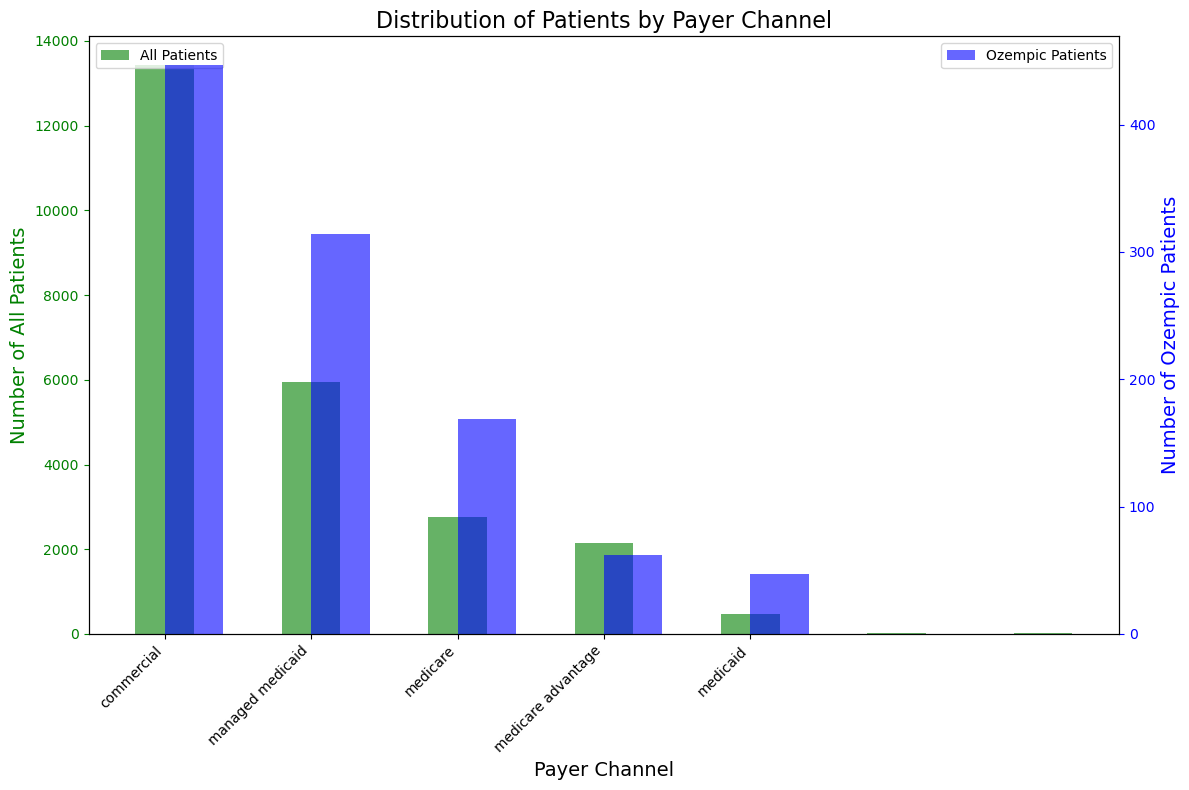

In [24]:
# Check distribution of payer channel for Obese/Hypertensive patients and Ozempic patients

# Create data of top 10 payer channel for Obese/Hypertensive patients
patients_payer_channel = data_merge.groupby(['payor_channel'])['journey_id'].count().reset_index(name='count')
patients_payer_channel_sorted = patients_payer_channel.sort_values('count', ascending=False)
patients_payer_channel_top5 = patients_payer_channel_sorted.head(10)

# Create data of top 10 payer channel for for Ozempic recipients
data_oz = data_merge[data_merge['treatment'] == 1]
patients_payer_channel_oz = data_oz.groupby(['payor_channel'])['journey_id'].count().reset_index(name='count')
patients_payer_channel_oz_sorted = patients_payer_channel_oz.sort_values('count', ascending=False)
patients_payer_channel_oz_top5 = patients_payer_channel_oz_sorted.head(10)


# Visualize
plt.figure(figsize=(12, 8))

# 1st bar plot for Obese/Hypertensive patients
ax1 = plt.gca() # get current axis
bars1 = ax1.bar(patients_payer_channel_top5['payor_channel'], patients_payer_channel_top5['count'], color='green', label='All Patients', alpha=0.6, width=0.4)

# 2nd bar plot for Obese/Hypertensive + Ozempic Patients + create a second y-axis for the second dataset
ax2 = ax1.twinx()
bars2 = ax2.bar(patients_payer_channel_oz_top5['payor_channel'], patients_payer_channel_oz_top5['count'], color='blue', label='Ozempic Patients', alpha=0.6, width=0.4, align='edge')

# Labels, title, and legends
ax1.set_xlabel('Payer Channel', fontsize=14)
ax1.set_ylabel('Number of All Patients', color='g', fontsize=14)
ax2.set_ylabel('Number of Ozempic Patients', color='b', fontsize=14)
plt.title('Distribution of Patients by Payer Channel', fontsize=16)

# Customizing the tick parameters
ax1.tick_params(axis='y', colors='green')
ax2.tick_params(axis='y', colors='blue')
ax1.set_xticklabels(patients_payer_channel_top5['payor_channel'], rotation=45, ha='right')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Most of obese or hypertensive patients were using commercial or private insurance payer covers the cost of medical care. Medicaid(state/federal program) and Medicare(Federal insurance program for 65+/individuals with specific diseases) exists, but commercial is dominant.

Observations reveal a consistent trend within the Ozempic-prescribed patient group. Also notably, there is a proportional increase in patients with managed medicaid, medicare coverage among those treated with Ozempic. Therefore, it suggests that payer channel, alongside place of service, could be considered an endogenous variable that impacts treatment selection.


/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_65650/1581602690.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(patients_visit_type_top5['visit_type'], rotation=45, ha='right')


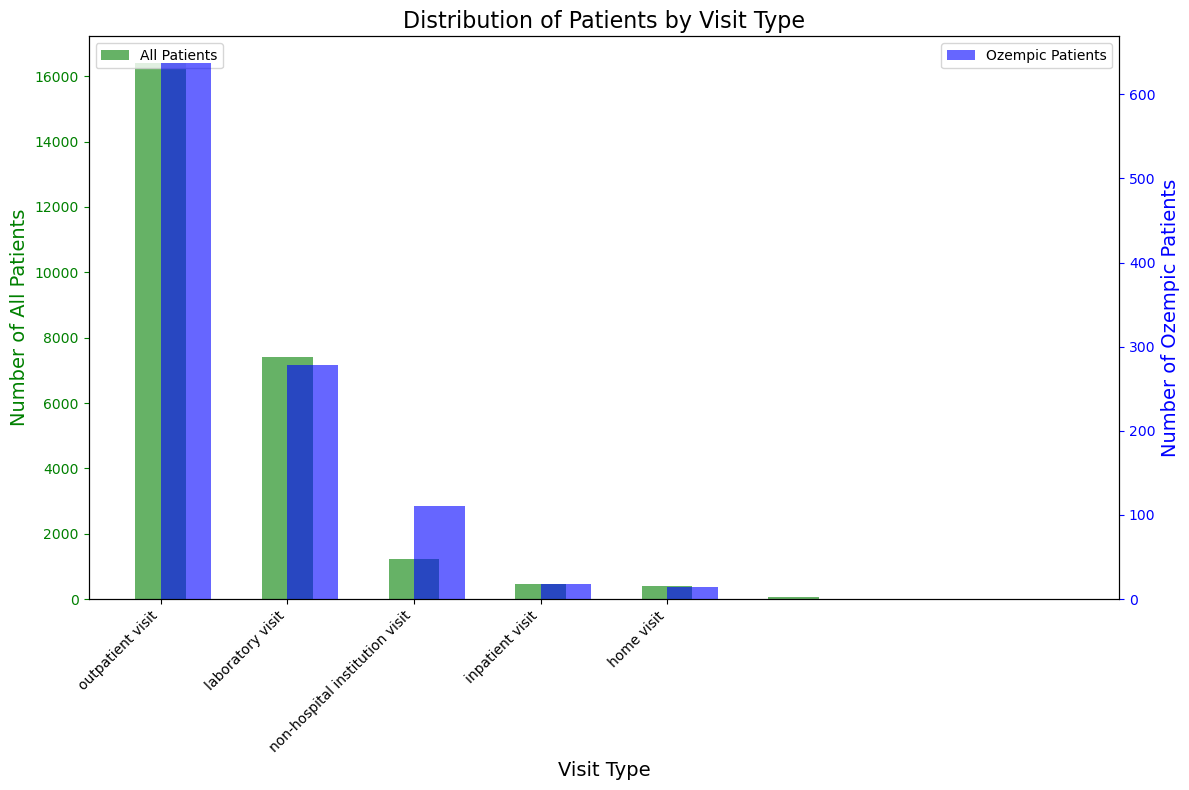

In [25]:
# Check distribution of visit type for Obese/Hypertensive patients and Ozempic patients

# Create data of top 10 visit type for Obese/Hypertensive patients
patients_visit_type = data_merge.groupby(['visit_type'])['journey_id'].count().reset_index(name='count')
patients_visit_type_sorted = patients_visit_type.sort_values('count', ascending=False)
patients_visit_type_top5 = patients_visit_type_sorted.head(10)

# Create data of top 10 visit for for Ozempic recipients
data_oz = data_merge[data_merge['treatment'] == 1]
patients_visit_type_oz = data_oz.groupby(['visit_type'])['journey_id'].count().reset_index(name='count')
patients_visit_type_oz_sorted = patients_visit_type_oz.sort_values('count', ascending=False)
patients_visit_type_oz_top5 = patients_visit_type_oz_sorted.head(10)


# Visualize
plt.figure(figsize=(12, 8))

# 1st bar plot for Obese/Hypertensive patients
ax1 = plt.gca() # get current axis
bars1 = ax1.bar(patients_visit_type_top5['visit_type'], patients_visit_type_top5['count'], color='green', label='All Patients', alpha=0.6, width=0.4)

# 2nd bar plot for Obese/Hypertensive + Ozempic Patients + create a second y-axis for the second dataset
ax2 = ax1.twinx()
bars2 = ax2.bar(patients_visit_type_oz_top5['visit_type'], patients_visit_type_oz_top5['count'], color='blue', label='Ozempic Patients', alpha=0.6, width=0.4, align='edge')

# Labels, title, and legends
ax1.set_xlabel('Visit Type', fontsize=14)
ax1.set_ylabel('Number of All Patients', color='g', fontsize=14)
ax2.set_ylabel('Number of Ozempic Patients', color='b', fontsize=14)
plt.title('Distribution of Patients by Visit Type', fontsize=16)

# Customizing the tick parameters
ax1.tick_params(axis='y', colors='green')
ax2.tick_params(axis='y', colors='blue')
ax1.set_xticklabels(patients_visit_type_top5['visit_type'], rotation=45, ha='right')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



For both the entire cohort of obese/hypertensive patients and those treated with Ozempic, 'outpatient visits' and 'laboratory visits' are the most frequent types of visits. Although there is no significant difference between the two groups, visits to non-hospital institutions occur proportionally more often in the Ozempic group. Thus, this also can be tested as endogenous variable that impacts treatment selection.


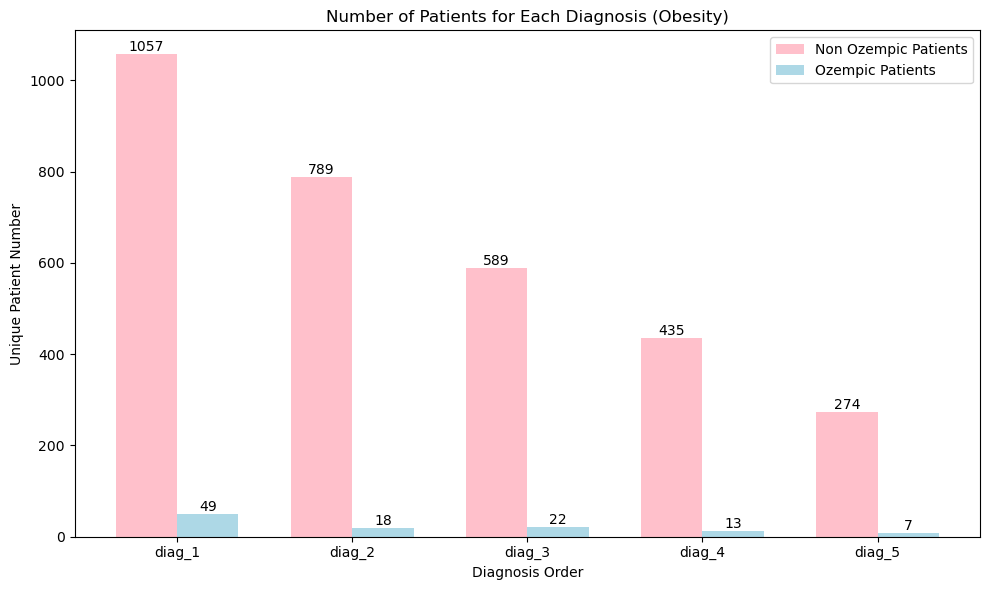

In [26]:
# Since the objective of the model is to investigate the effectiveness of Ozempic on obesity and hypertension. Thus, we should carefully check if the diagnosis for these desease has been significantly decreased after applying the treatment(in this case Ozempic).
# To check if this idea is valid, check if the number of diagnosis for the desease shows declining trend, especially for those who received Ozempic.
# Diagnosis codes to try: 'E66', 'I10'

## 1. Obesity

# Define the relevant diagnosis codes
diag_code = 'E66'

data_oz = data_merge[data_merge['treatment'] == 1]
data_non_oz = data_merge[data_merge['treatment'] == 0]

# Initialize dictionaries to save the counts for each diagnosis
diag_counts_non_ozempic = {}
diag_counts_ozempic = {}


# with for loop, iterate over each diagnosis column and count unique journey_ids for the diagnosis codes
for i in range(1, 6):
    diag_n = f'diag_{i}'
    mask_non_ozempic = data_non_oz[diag_n].fillna('').str.startswith(diag_code)
    mask_ozempic = data_oz[diag_n].fillna('').str.startswith(diag_code)

    d_cnt_non_ozempic = data_non_oz.loc[mask_non_ozempic, 'journey_id'].nunique()
    d_cnt_ozempic = data_oz.loc[mask_ozempic, 'journey_id'].nunique()

    diag_counts_non_ozempic[diag_n] = d_cnt_non_ozempic
    diag_counts_ozempic[diag_n] = d_cnt_ozempic

# Convert to DataFrames and merge to one
df_diag_counts_non_ozempic = pd.DataFrame(list(diag_counts_non_ozempic.items()), columns=['Diagnosis Order', 'Unique Patient Number - Non Ozempic'])
df_diag_counts_ozempic = pd.DataFrame(list(diag_counts_ozempic.items()), columns=['Diagnosis Order', 'Unique Patient Number - Ozempic'])
df_diag_counts = pd.merge(df_diag_counts_non_ozempic, df_diag_counts_ozempic, on='Diagnosis Order')

# Plot a bar plot, side by side
bar_width = 0.35
index = np.arange(len(df_diag_counts['Diagnosis Order']))

plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, df_diag_counts['Unique Patient Number - Non Ozempic'], bar_width, label='Non Ozempic Patients', color='pink')
bars2 = plt.bar(index + bar_width, df_diag_counts['Unique Patient Number - Ozempic'], bar_width, label='Ozempic Patients', color='lightblue')

# Add labels and title
plt.xlabel('Diagnosis Order')
plt.ylabel('Unique Patient Number')
plt.title('Number of Patients for Each Diagnosis (Obesity)')
plt.xticks(index + bar_width / 2, df_diag_counts['Diagnosis Order'])

# Adding legend
plt.legend()

# Optional: Add value labels on top of each bar
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


We can observe that patients diagnosed with obesity as their primary diagnosis are likely to have these conditions resolved by the time of their last diagnosis, indicating a declining trend over time. However, We need to prove if this is  due to Ozempic.

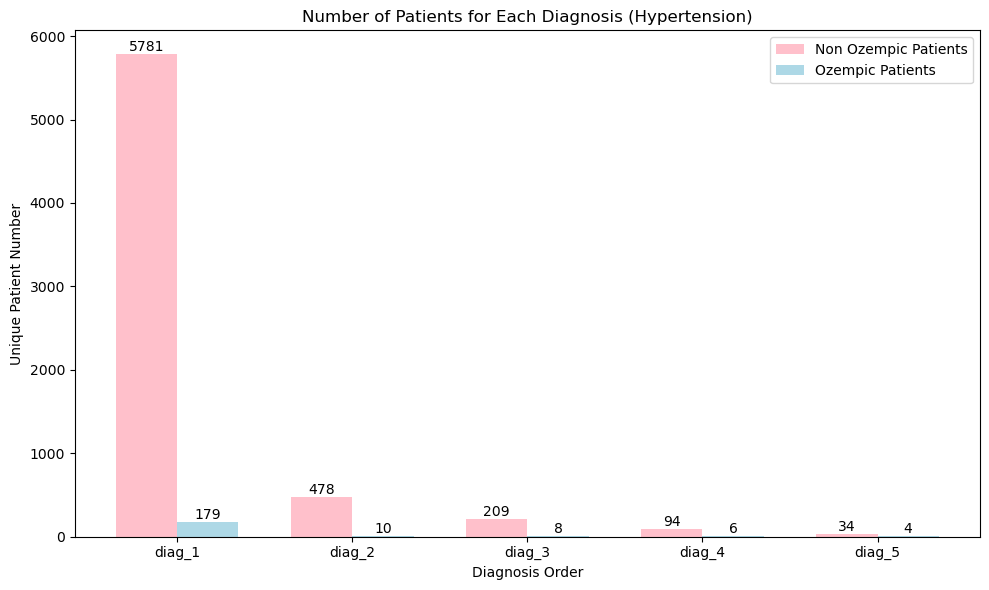

In [27]:
# Since the objective of the model is to investigate the effectiveness of Ozempic on obesity and hypertension. Thus, we should carefully check if the diagnosis for these desease has been significantly decreased after applying the treatment(in this case Ozempic).
# To check if this idea is valid, check if the number of diagnosis for the desease shows declining trend, especially for those who received Ozempic.
# Diagnosis codes to try: 'E66', 'I10', 'E78', 'E11'

## 2. Hypertension

# Define the relevant diagnosis codes
diag_code = 'I10'

data_oz = data_merge[data_merge['treatment'] == 1]
data_non_oz = data_merge[data_merge['treatment'] == 0]

# Initialize dictionaries to save the counts for each diagnosis
diag_counts_non_ozempic = {}
diag_counts_ozempic = {}


# with for loop, iterate over each diagnosis column and count unique journey_ids for the diagnosis codes
for i in range(1, 6):
    diag_n = f'diag_{i}'
    mask_non_ozempic = data_non_oz[diag_n].fillna('').str.startswith(diag_code)
    mask_ozempic = data_oz[diag_n].fillna('').str.startswith(diag_code)

    d_cnt_non_ozempic = data_non_oz.loc[mask_non_ozempic, 'journey_id'].nunique()
    d_cnt_ozempic = data_oz.loc[mask_ozempic, 'journey_id'].nunique()

    diag_counts_non_ozempic[diag_n] = d_cnt_non_ozempic
    diag_counts_ozempic[diag_n] = d_cnt_ozempic

# Convert to DataFrames and merge to one
df_diag_counts_non_ozempic = pd.DataFrame(list(diag_counts_non_ozempic.items()), columns=['Diagnosis Order', 'Unique Patient Number - Non Ozempic'])
df_diag_counts_ozempic = pd.DataFrame(list(diag_counts_ozempic.items()), columns=['Diagnosis Order', 'Unique Patient Number - Ozempic'])
df_diag_counts = pd.merge(df_diag_counts_non_ozempic, df_diag_counts_ozempic, on='Diagnosis Order')

# Plot a bar plot, side by side
bar_width = 0.35
index = np.arange(len(df_diag_counts['Diagnosis Order']))

plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, df_diag_counts['Unique Patient Number - Non Ozempic'], bar_width, label='Non Ozempic Patients', color='pink')
bars2 = plt.bar(index + bar_width, df_diag_counts['Unique Patient Number - Ozempic'], bar_width, label='Ozempic Patients', color='lightblue')

# Add labels and title
plt.xlabel('Diagnosis Order')
plt.ylabel('Unique Patient Number')
plt.title('Number of Patients for Each Diagnosis (Hypertension)')
plt.xticks(index + bar_width / 2, df_diag_counts['Diagnosis Order'])

# Adding legend
plt.legend()

# Optional: Add value labels on top of each bar
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


For hypertensive patients, the declining trend is more clear than that of obese patients. It is noticeable that only 10 patients left in the second diagnosis already

(array([2730., 2173., 1715., 2302., 3275., 2959., 3856., 2368., 3429.,
        2234.]),
 array([18993. , 19056.2, 19119.4, 19182.6, 19245.8, 19309. , 19372.2,
        19435.4, 19498.6, 19561.8, 19625. ]),
 <BarContainer object of 10 artists>)

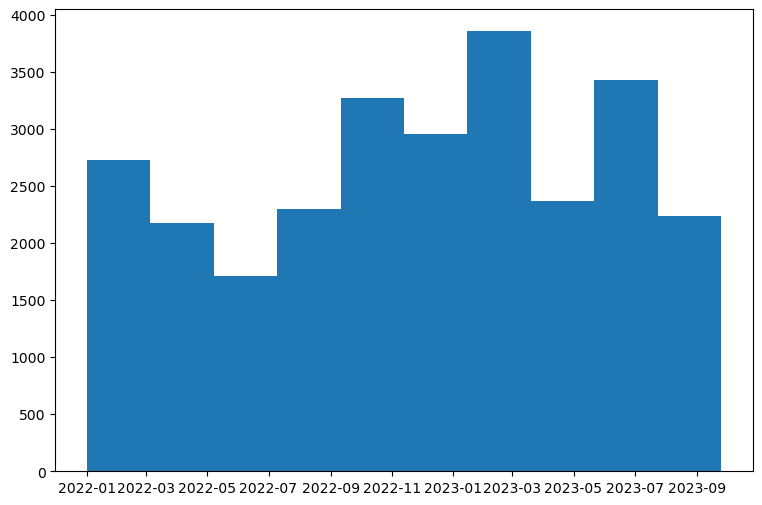

In [28]:
# The distribution of claim date: No significant seasonality or trend detected
plt.figure(figsize=(9, 6))
plt.hist(pd.to_datetime(data_merge['claim_date']))

In [29]:
# Check the patient zip code and extract top 10 areas having greatest number of obese/hypertensive patients and Ozempic prescribed people
# Import an external dataset to map zip code and city/district name with zipcode
# data Source: https://simple.wikipedia.org/wiki/List_of_ZIP_Code_prefixes

zipcode = pd.read_excel("zipcode.xlsx")
zipcode.head()

,zipcode,state,city,city2
0,900,CA,Los Angeles,LOS ANGELES
1,901,CA,Los Angeles,LOS ANGELES
2,902,CA,Inglewood,"Beverly Hills, Culver City, Towns in Southern ..."
3,903,CA,Inglewood,INGLEWOOD
4,904,CA,Inglewood,SANTA MONICA


In [30]:
# Merge two datasets
data_merge2 = pd.merge(data_merge, zipcode, left_on='patient_short_zip',right_on='zipcode', how='left')

# Select only the first letter in diagnosis
data_merge2['diag_1'] = data_merge2['diag_1'].str[:3]
data_merge2['diag_2'] = data_merge2['diag_2'].str[:3]
data_merge2['diag_3'] = data_merge2['diag_3'].str[:3]
data_merge2['diag_4'] = data_merge2['diag_4'].str[:3]
data_merge2['diag_5'] = data_merge2['diag_5'].str[:3]

data_merge2.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,line_charge,claim_charge,smart_allowed,quantity_dispensed,days_supply,treatment,zipcode,state,city,city2
0,00025243850b83969606f3f2aafc2d99,67f4df54bf85e427589ed1cd425270f6,6b7c9e01419fcd1fba69c3f1a44b5d9e81967db789bf21...,2db3a06e836eb02dedad5f3982685cee7376282a619af5...,2022-07-21,CA,910.0,70.0,F,NaN,...,175.00,175.00,0.00,0.0,0.0,0,910,CA,Pasadena,"Arcadia, La Canada, areas around Pasadena"
1,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,0.01,0.01,56.38,0.0,0.0,0,900,CA,Los Angeles,LOS ANGELES
2,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,0.01,0.01,44.68,0.0,0.0,0,900,CA,Los Angeles,LOS ANGELES
3,0004094aa2ec57dd99b186ace5070625,1fc12255b88e07a93feb523819cba93c,1f5bccba82c4b0acb2e1cf8ad92e2c6a07cd8a9fa56c80...,0259050a90196f1e191aee50a2981dc032e52626ba86f5...,2023-05-26,CA,900.0,65.0,M,Office,...,0.01,0.01,48.46,0.0,0.0,0,900,CA,Los Angeles,LOS ANGELES
4,0004bed2670fd243392dc3a994da3f8a,ddd181f11bb36a27b920c61df51ca642,9e73758d2163af00d8005682f202cd6f6d339e9a692d78...,39a76631c902efb924077e77aeda59f9af6b582444e5c0...,2022-08-29,CA,911.0,50.0,M,Independent Clinic,...,0.00,0.00,129.72,0.0,0.0,0,911,CA,Pasadena,PASADENA


In [31]:
data_oz = data_merge2[data_merge2['treatment'] == 1] # Add citi names to the Ozempic prescribed patient data
data_oz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 8 to 27026
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   journey_id          1096 non-null   object 
 1   episode_id          1096 non-null   object 
 2   visit_id            1096 non-null   object 
 3   encounter_id        1096 non-null   object 
 4   claim_date          1096 non-null   object 
 5   patient_state       1096 non-null   object 
 6   patient_short_zip   1096 non-null   float64
 7   patient_age         1096 non-null   float64
 8   patient_gender      1096 non-null   object 
 9   place_of_service    886 non-null    object 
 10  visit_type          1058 non-null   object 
 11  payor               1080 non-null   object 
 12  payor_channel       1039 non-null   object 
 13  ref_npi             574 non-null    float64
 14  hcp_npi             704 non-null    float64
 15  hcp_taxonomy        695 non-null    object 
 16  hcp_s

In [32]:
# The proportion of Ozempic prescribed patients out of patients for each disease/city
pd.set_option('display.max_rows', None)
ttl_patients = data_merge2.groupby(['diag_1','city'])['journey_id'].count()
oz_patients = data_oz.groupby(['diag_1','city'])['journey_id'].count()

print(oz_patients/ttl_patients)

diag_1  city        
E66     Long Beach      0.010830
        Los Angeles     0.029386
        Palm Springs    0.026059
        Pasadena        0.026749
        San Diego       0.152648
        Van Nuys        0.020305
I10     Chicago              NaN
        Long Beach      0.015993
        Los Angeles     0.025737
        Palm Springs    0.051824
        Pasadena        0.070307
        San Diego       0.026802
        Van Nuys        0.017470
Name: journey_id, dtype: float64


The analysis of patient zip codes reveals that for obesity, San Diego exhibits the highest Ozempic prescription rate.

For hypertension, Pasadena shows the highest Ozempic prescription rate.

As stated above, the Ozempic prescription rate for certain diseases tends to be skewed. Thus, we will include the city name as a variable that affects the treatment.

Through the information above, we have been suspicious that some demographic information might have relationship with Ozempic prescription. So we looked for external data we can use for the dataset which are available in zip code level. 

1. 2022 House Price Index by zip code (https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx)
2. Median Income by county
3. Obesity Rate by County (https://www.ruralhealthinfo.org/charts/39?state=CA)

In [33]:
# Import all datasets
df_hpi = pd.read_csv("housepriceindex_f.csv") # HPI of 2022, available by 3 digit zip code 
df_income = pd.read_csv("2023-income-limits.csv") # Income by county, need to join with zip code
df_obesity_rate = pd.read_csv("CAObesityPrevalence.csv") # Obesity rate by county, need to join with zip code
df_zip_county = pd.read_excel("california_county_zip_map.xlsx") # 3 digit zip code by county

In [34]:
df_income.head()

df_obesity_rate.head()

#df_zip_county.head()

,metro_nonmetro,county,state_abbr,geoId,obesity_rate
0,Metropolitan,Alameda,CA,us-ca-001,0.220000
1,Metropolitan,Butte,CA,us-ca-007,0.303001
2,Metropolitan,Contra Costa,CA,us-ca-013,0.249000
3,Metropolitan,El Dorado,CA,us-ca-017,0.252000
4,Metropolitan,Fresno,CA,us-ca-019,0.330000


In [35]:
# merge income dataset and zip code dataset
df_income2 = pd.merge(df_income, df_zip_county, left_on='County', right_on='county', how='inner')
df_income2 = df_income2[['zip_3', 'AMI']]

df_income2 = df_income2.groupby(['zip_3'])['AMI'].mean().reset_index() # aggregate obesity rate value to avoid duplication

df_income2.head()

,zip_3,AMI
0,900,98200.0
1,901,98200.0
2,902,98200.0
3,903,98200.0
4,904,98200.0


In [36]:
# merge obesity rate dataset and zip code dataset
df_obesity_rate2 = pd.merge(df_obesity_rate, df_zip_county, left_on='county', right_on='county', how='inner')
df_obesity_rate2 = df_obesity_rate2[['zip_3', 'metro_nonmetro', 'county', 'obesity_rate']]

df_obesity_rate2 = df_obesity_rate2.groupby(['zip_3', 'metro_nonmetro', 'county'])['obesity_rate'].mean().reset_index() # aggregate obesity rate value to avoid duplication

df_obesity_rate2.head()

,zip_3,metro_nonmetro,county,obesity_rate
0,900,Metropolitan,Los Angeles,0.218
1,901,Metropolitan,Los Angeles,0.218
2,902,Metropolitan,Los Angeles,0.218
3,903,Metropolitan,Los Angeles,0.218
4,904,Metropolitan,Los Angeles,0.218


In [37]:
# merge all dataset 

# original dataset with HPI data
data_merge3 = pd.merge(data_merge2, df_hpi, left_on='patient_short_zip', right_on='zipcode', how='inner')

# original dataset with median income data
data_merge3 = pd.merge(data_merge3, df_income2, left_on='patient_short_zip', right_on='zip_3', how='inner')

# original dataset with obesity rate data
data_merge3 = pd.merge(data_merge3, df_obesity_rate2, left_on='patient_short_zip', right_on='zip_3', how='inner')

data_merge3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45637 entries, 0 to 45636
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   journey_id          45637 non-null  object 
 1   episode_id          45637 non-null  object 
 2   visit_id            45618 non-null  object 
 3   encounter_id        45637 non-null  object 
 4   claim_date          45637 non-null  object 
 5   patient_state       45637 non-null  object 
 6   patient_short_zip   45637 non-null  float64
 7   patient_age         45637 non-null  float64
 8   patient_gender      45637 non-null  object 
 9   place_of_service    38490 non-null  object 
 10  visit_type          43723 non-null  object 
 11  payor               43341 non-null  object 
 12  payor_channel       41960 non-null  object 
 13  ref_npi             22972 non-null  float64
 14  hcp_npi             31791 non-null  float64
 15  hcp_taxonomy        31580 non-null  object 
 16  hcp_

In [38]:
data_merge3.head() # Duplication exists due to scope of zip code, but this will be resolved later

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,city2,zipcode_y,year,hpi,zip_3_x,AMI,zip_3_y,metro_nonmetro,county,obesity_rate
0,00025243850b83969606f3f2aafc2d99,67f4df54bf85e427589ed1cd425270f6,6b7c9e01419fcd1fba69c3f1a44b5d9e81967db789bf21...,2db3a06e836eb02dedad5f3982685cee7376282a619af5...,2022-07-21,CA,910.0,70.0,F,NaN,...,"Arcadia, La Canada, areas around Pasadena",910,2022,2229.28,910,98200.0,910,Metropolitan,Los Angeles,0.218
1,0007706c4192472e8a9b01f11fbf32c7,527f8507e9cb5895705832cb136c565c,7e598bdc801e9f803b500452e1e528d81dc2f9049137c7...,0a6632b6212e5b04aea78cce6df2deb04f0a53cacdc0f5...,2022-12-19,CA,910.0,55.0,F,Office,...,"Arcadia, La Canada, areas around Pasadena",910,2022,2229.28,910,98200.0,910,Metropolitan,Los Angeles,0.218
2,0007706c4192472e8a9b01f11fbf32c7,527f8507e9cb5895705832cb136c565c,7e598bdc801e9f803b500452e1e528d81dc2f9049137c7...,0a6632b6212e5b04aea78cce6df2deb04f0a53cacdc0f5...,2022-12-19,CA,910.0,55.0,F,Office,...,"Arcadia, La Canada, areas around Pasadena",910,2022,2229.28,910,98200.0,910,Metropolitan,Los Angeles,0.218
3,0007706c4192472e8a9b01f11fbf32c7,527f8507e9cb5895705832cb136c565c,7e598bdc801e9f803b500452e1e528d81dc2f9049137c7...,0a6632b6212e5b04aea78cce6df2deb04f0a53cacdc0f5...,2022-12-19,CA,910.0,55.0,F,Office,...,"Arcadia, La Canada, areas around Pasadena",910,2022,2229.28,910,98200.0,910,Metropolitan,Los Angeles,0.218
4,0007706c4192472e8a9b01f11fbf32c7,9ddd836942f76999c582a675bdc12846,a68bf7f3c2b379f7ba39a5482852a5222e61549f796b48...,4bd7bf0b6237fce3cb2ba561ba2c1d2c0555f7cfe40a33...,2022-09-09,CA,910.0,55.0,F,Office,...,"Arcadia, La Canada, areas around Pasadena",910,2022,2229.28,910,98200.0,910,Metropolitan,Los Angeles,0.218


In [39]:
# Divide dataset into 2 parts, depending on the primary diagnosis 
data_obesity = data_merge3[data_merge3['diag_1']=='E66']
data_hypertension = data_merge3[data_merge3['diag_1']=='I10']

In [40]:
# Change the diag_n columns into numeric values 

#Obesity dataset 
data_obesity['diag_2'] = np.where(data_obesity['diag_2']== "E66", 1, 0)
data_obesity['diag_3'] = np.where(data_obesity['diag_3']== "E66", 1, 0)
data_obesity['diag_4'] = np.where(data_obesity['diag_4']== "E66", 1, 0)
data_obesity['diag_5'] = np.where(data_obesity['diag_5']== "E66", 1, 0)

#Hypertension
data_hypertension['diag_2'] = np.where(data_hypertension['diag_2']=="I10", 1, 0)
data_hypertension['diag_3'] = np.where(data_hypertension['diag_3']=="I10", 1, 0)
data_hypertension['diag_4'] = np.where(data_hypertension['diag_4']=="I10", 1, 0)
data_hypertension['diag_5'] = np.where(data_hypertension['diag_5']=="I10", 1, 0)

/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_65650/1928780017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obesity['diag_2'] = np.where(data_obesity['diag_2']== "E66", 1, 0)
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_65650/1928780017.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obesity['diag_3'] = np.where(data_obesity['diag_3']== "E66", 1, 0)
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_65650/1928780017.py:6: SettingWithCopyWarning: 
A val

In [41]:
data_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5398 entries, 28 to 45624
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   journey_id          5398 non-null   object 
 1   episode_id          5398 non-null   object 
 2   visit_id            5398 non-null   object 
 3   encounter_id        5398 non-null   object 
 4   claim_date          5398 non-null   object 
 5   patient_state       5398 non-null   object 
 6   patient_short_zip   5398 non-null   float64
 7   patient_age         5398 non-null   float64
 8   patient_gender      5398 non-null   object 
 9   place_of_service    4155 non-null   object 
 10  visit_type          4706 non-null   object 
 11  payor               5020 non-null   object 
 12  payor_channel       4845 non-null   object 
 13  ref_npi             2143 non-null   float64
 14  hcp_npi             3847 non-null   float64
 15  hcp_taxonomy        3776 non-null   object 
 16  hcp_

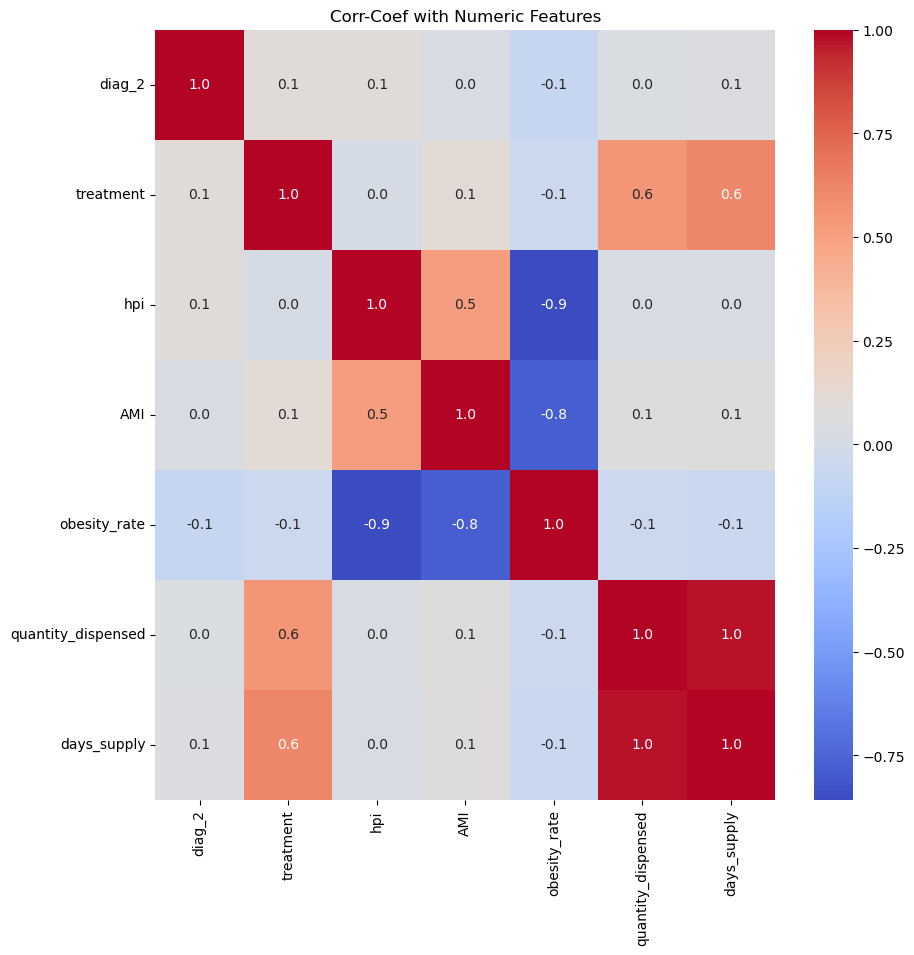

In [42]:
# Heatmap to identify any correlation between 2 features

## 1. Obesity 
corr_coef = data_obesity.loc[:,['diag_2', 'treatment', 'hpi', 'AMI', 'obesity_rate', 'quantity_dispensed', 'days_supply']].corr() # create a correlation-coefficient matrix

# Plot a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_coef, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Corr-Coef with Numeric Features")
plt.show()

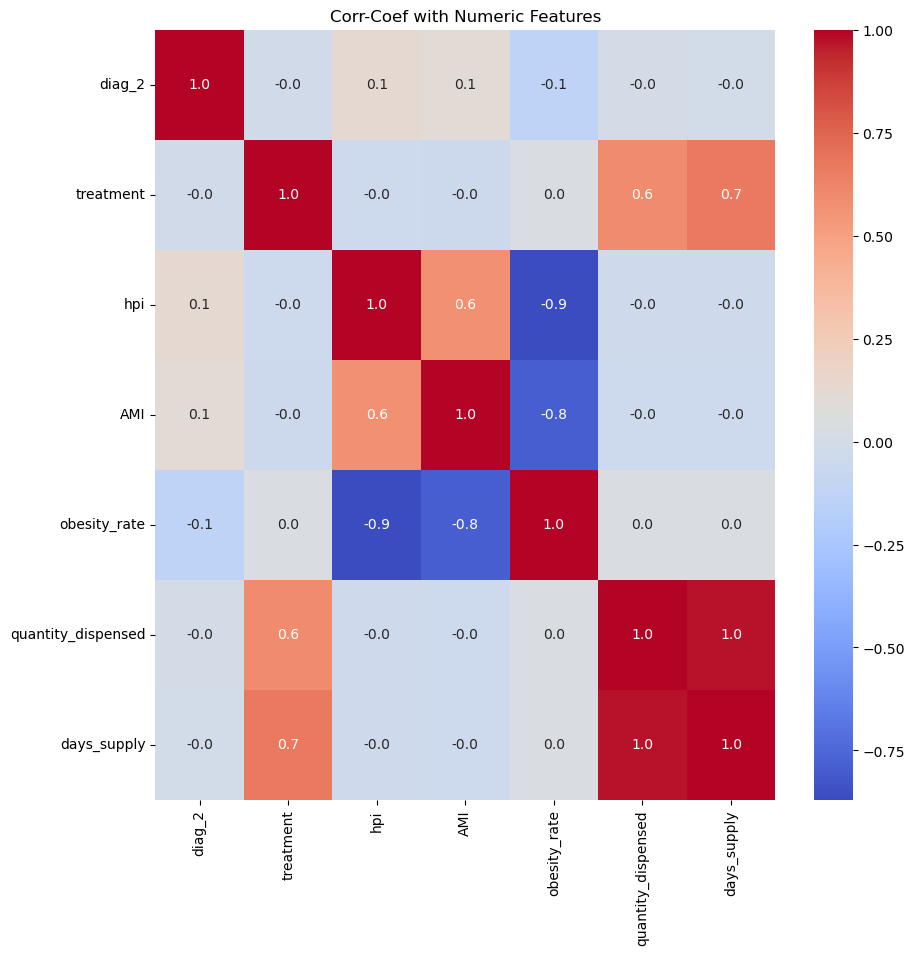

In [43]:
## 2. Hypertension
corr_coef = data_hypertension.loc[:,['diag_2', 'treatment', 'hpi', 'AMI', 'obesity_rate', 'quantity_dispensed', 'days_supply']].corr() # create a correlation-coefficient matrix

# Plot a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_coef, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Corr-Coef with Numeric Features")
plt.show()

**Observation**

1. Overall, the pattern that the heatmap shows is consistent across all diseases.
2. There's a perfect correlation between quantity dispensed and days supply. Thus, we include only one of these two variables in the model.
3. HPI and Obesity Rate have a strong negative correlation. This means that wealthier people are less likely to be obese, which aligns with our common belief. Median income (AMI) and obesity rate essentially provide the same information.
4. Treatment doesn't seem to be very impactful, just looking at the heatmaps for all 4 diseases since the correlation coefficients are close to zero.

#### **2. Causal Analysis Setup**

In [44]:
data_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5398 entries, 28 to 45624
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   journey_id          5398 non-null   object 
 1   episode_id          5398 non-null   object 
 2   visit_id            5398 non-null   object 
 3   encounter_id        5398 non-null   object 
 4   claim_date          5398 non-null   object 
 5   patient_state       5398 non-null   object 
 6   patient_short_zip   5398 non-null   float64
 7   patient_age         5398 non-null   float64
 8   patient_gender      5398 non-null   object 
 9   place_of_service    4155 non-null   object 
 10  visit_type          4706 non-null   object 
 11  payor               5020 non-null   object 
 12  payor_channel       4845 non-null   object 
 13  ref_npi             2143 non-null   float64
 14  hcp_npi             3847 non-null   float64
 15  hcp_taxonomy        3776 non-null   object 
 16  hcp_

select variables for the model based on findings from the EDA stage.

- X variables:
place_of_service, visit_type, payor_channel, quantity_dispensed, treatment, city, hpi, AMI, metro_nonmetro, obesity_rate

- y variable:
diag_2

In [45]:
# Choose variables that will be used for model creation
data_obesity2 = data_obesity.loc[:,['journey_id','place_of_service','visit_type', 'payor_channel', 'quantity_dispensed', 'treatment', 'city', 'hpi', 'AMI', 'metro_nonmetro', 'obesity_rate','diag_2']]
data_obesity2 = data_obesity2.drop_duplicates(keep='last') # drop duplcated rows

data_hypertension2 = data_hypertension.loc[:,['journey_id','place_of_service','visit_type', 'payor_channel', 'quantity_dispensed', 'treatment', 'city', 'hpi', 'AMI', 'metro_nonmetro', 'obesity_rate','diag_2']]
data_hypertension2 = data_hypertension2.drop_duplicates(keep='last') # drop duplcated rows

In [46]:
# Check the number of missing values
data_obesity2.isnull().sum()

journey_id              0
place_of_service      427
visit_type            228
payor_channel         132
quantity_dispensed      0
treatment               0
city                    0
hpi                     0
AMI                     0
metro_nonmetro          0
obesity_rate            0
diag_2                  0
dtype: int64

In [47]:
# Fill the place_of_service, visit type, and payor_channel with "None" when they're NaN
data_obesity2['place_of_service'] = data_obesity2['place_of_service'].fillna("None")
data_obesity2['visit_type'] = data_obesity2['visit_type'].fillna("None")
data_obesity2['payor_channel'] = data_obesity2['payor_channel'].fillna("None")

data_hypertension2['place_of_service'] = data_hypertension2['place_of_service'].fillna("None")
data_hypertension2['visit_type'] = data_hypertension2['visit_type'].fillna("None")
data_hypertension2['payor_channel'] = data_hypertension2['payor_channel'].fillna("None")

# Drop rows without place of service, visit type, and payer channel
#data_select = data_select.dropna(subset=['place_of_service', 'visit_type', 'payor_channel'])

# Fill the missing values in quantity dispensed with 0

data_obesity2['quantity_dispensed'] = data_obesity2['quantity_dispensed'].fillna(0)

data_hypertension2['quantity_dispensed'] = data_hypertension2['quantity_dispensed'].fillna(0)


data_obesity2.isnull().sum()

journey_id            0
place_of_service      0
visit_type            0
payor_channel         0
quantity_dispensed    0
treatment             0
city                  0
hpi                   0
AMI                   0
metro_nonmetro        0
obesity_rate          0
diag_2                0
dtype: int64

In [48]:
# Convert categorical variables to dummies
data_obesity3 =pd.get_dummies(data_obesity2, columns=['place_of_service', 'visit_type', 'payor_channel', 'city', 'metro_nonmetro'])

data_hypertension3 =pd.get_dummies(data_hypertension2, columns=['place_of_service', 'visit_type', 'payor_channel', 'city', 'metro_nonmetro'])

data_obesity3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 35 to 45624
Data columns (total 47 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   journey_id                                                         1951 non-null   object 
 1   quantity_dispensed                                                 1951 non-null   float64
 2   treatment                                                          1951 non-null   int64  
 3   hpi                                                                1951 non-null   float64
 4   AMI                                                                1951 non-null   float64
 5   obesity_rate                                                       1951 non-null   float64
 6   diag_2                                                             1951 non-null   int64  
 7   place_of_service_Ambul

In [49]:
# Select dummy variables that have notable difference between treatment/control in EDA

#Place of service - independent laboratory, federally qualified health center, home, inpatient hospital, independent clinic
#Payer channel - managed medicaid, medicare
#Visit type - non-hospital institutions

data_obesity4 = data_obesity3.iloc[:,[0,1,2,3,4,5,6,12,13,14,15,16,31,35,37,40,41,42,43,44,45]]

data_hypertension4 = data_hypertension3.iloc[:,[0,1,2,3,4,5,6,10,11,12,13,14,31,36,38,42,43,44,45,46,47]]

data_obesity4.head()

,journey_id,quantity_dispensed,treatment,hpi,AMI,obesity_rate,diag_2,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,...,place_of_service_Inpatient Hospital,visit_type_non-hospital institution visit,payor_channel_managed medicaid,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys
35,00760a214dbfabe94557c0a038dcc5a0,0.0,0,2229.28,98200.0,0.218,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
57,00a85f1ae5fc0552dcec35f796a8f02f,0.0,0,2229.28,98200.0,0.218,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100,0135df7bc63a731bfed57d7063ebe3cd,0.0,0,2229.28,98200.0,0.218,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
103,016f4c64445aec2291181214354896c8,0.0,0,2229.28,98200.0,0.218,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
124,02d7943ccd8c67a3c4b4e5f1da98a7e0,0.0,0,2229.28,98200.0,0.218,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [50]:
print(len(data_obesity4['journey_id']), data_obesity4['journey_id'].nunique()) # There's overap in journeu_id → use groupby so that one patient have one row.

1951 1106


In [51]:
data_obesity4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 35 to 45624
Data columns (total 21 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   journey_id                                          1951 non-null   object 
 1   quantity_dispensed                                  1951 non-null   float64
 2   treatment                                           1951 non-null   int64  
 3   hpi                                                 1951 non-null   float64
 4   AMI                                                 1951 non-null   float64
 5   obesity_rate                                        1951 non-null   float64
 6   diag_2                                              1951 non-null   int64  
 7   place_of_service_Federally Qualified Health Center  1951 non-null   uint8  
 8   place_of_service_Home                               1951 non-null   uint8  


In [52]:
# List of columns to exclude from aggregation
exclude_columns = ['journey_id']

# Create an aggregation dictionary
# Include all columns except journey id, applying 'max' aggregation
agg_dict_o = {col: 'max' for col in data_obesity4.columns if col not in exclude_columns}
agg_dict_h = {col: 'max' for col in data_hypertension4.columns if col not in exclude_columns}

# Perform the groupby and aggregation
data_obesity5 = data_obesity4.groupby('journey_id', as_index=False).agg(agg_dict_o)
data_hypertension5 = data_hypertension4.groupby('journey_id', as_index=False).agg(agg_dict_h)

# Display the info of the resulting DataFrame
data_obesity5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 21 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   journey_id                                          1106 non-null   object 
 1   quantity_dispensed                                  1106 non-null   float64
 2   treatment                                           1106 non-null   int64  
 3   hpi                                                 1106 non-null   float64
 4   AMI                                                 1106 non-null   float64
 5   obesity_rate                                        1106 non-null   float64
 6   diag_2                                              1106 non-null   int64  
 7   place_of_service_Federally Qualified Health Center  1106 non-null   uint8  
 8   place_of_service_Home                               1106 non-null   uint8  
 9

#### **3. Model Development**

Models to try:

1. Linear Regression
2. LASSO (Linear) Regression
3. Double LASSO Regression

In [53]:
# Split dataset into features, target, and treatment

## Obesity
X_o = data_obesity5.drop(['journey_id', 'diag_2', 'treatment'], axis=1)
d_o = data_obesity5['treatment'] # Treatment indicator
y_o = data_obesity5['diag_2']

## Hypertension
X_h = data_hypertension5.drop(['journey_id', 'diag_2', 'treatment'], axis=1)
d_h = data_hypertension5['treatment'] # Treatment indicator
y_h = data_hypertension5['diag_2']

X_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 18 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   quantity_dispensed                                  1106 non-null   float64
 1   hpi                                                 1106 non-null   float64
 2   AMI                                                 1106 non-null   float64
 3   obesity_rate                                        1106 non-null   float64
 4   place_of_service_Federally Qualified Health Center  1106 non-null   uint8  
 5   place_of_service_Home                               1106 non-null   uint8  
 6   place_of_service_Independent Clinic                 1106 non-null   uint8  
 7   place_of_service_Independent Laboratory             1106 non-null   uint8  
 8   place_of_service_Inpatient Hospital                 1106 non-null   uint8  
 9

We don't need to split data into test/train set, since the objective of training this model is not to predict the patients' change in diagnosis.
Rather, we want to determine if the treatment(Ozempic prescription) has a significant impact on patients' change in obesity/hypertension diagnosis within this specific dataset.
Thus in this case, we would focus on getting coefficients of treatment and covariates.

##### 1) Linear Regression

In [54]:
# Fit the general linear regression model, only with the treatment variable for comparison

## Obesity

d_constant = sm.add_constant(d_o)
model_treatment_only = sm.OLS(y_o, d_constant).fit()

# Print the summary
print(model_treatment_only.summary())

                            OLS Regression Results                            
Dep. Variable:                 diag_2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.001182
Date:                Sat, 30 Mar 2024   Prob (F-statistic):              0.973
Time:                        11:17:44   Log-Likelihood:                0.52018
No. Observations:                1106   AIC:                             2.960
Df Residuals:                    1104   BIC:                             12.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0624      0.007      8.386      0.0

Obesity: The treatment coefficient is negative but statistically not significant

In [55]:
## Hypertension

d_constant = sm.add_constant(d_h)
model_treatment_only = sm.OLS(y_h, d_constant).fit()

# Print the summary
print(model_treatment_only.summary())

                            OLS Regression Results                            
Dep. Variable:                 diag_2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.483
Date:                Sat, 30 Mar 2024   Prob (F-statistic):              0.115
Time:                        11:17:44   Log-Likelihood:                 397.63
No. Observations:                5960   AIC:                            -791.3
Df Residuals:                    5958   BIC:                            -777.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0550      0.003     18.474      0.0

Hypertension: The treatment coefficient is negative but statistically not significant

Overall, all treatment coefficients and their p-values are questionable.

In [56]:
# Now try fitting a linear model with all other X variables with treatment and see what happens

## Obesity

X2_o = data_obesity5.drop(['journey_id', 'diag_2'], axis=1)

# Add a constant
X2_o_constant = sm.add_constant(X2_o)

# Fit the model
model_all_vars = sm.OLS(y_o, X2_o_constant).fit()

# Print the summary
print(model_all_vars.summary())

                            OLS Regression Results                            
Dep. Variable:                 diag_2   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     9.414
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           2.11e-23
Time:                        11:17:45   Log-Likelihood:                 76.412
No. Observations:                1106   AIC:                            -116.8
Df Residuals:                    1088   BIC:                            -26.67
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [57]:
## Hypertension

X2_h = data_hypertension5.drop(['journey_id', 'diag_2'], axis=1)

# Add a constant
X2_h_constant = sm.add_constant(X2_h)

# Fit the model
model_all_vars = sm.OLS(y_h, X2_h_constant).fit()

# Print the summary
print(model_all_vars.summary())

                            OLS Regression Results                            
Dep. Variable:                 diag_2   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     78.98
Date:                Sat, 30 Mar 2024   Prob (F-statistic):          5.14e-260
Time:                        11:17:45   Log-Likelihood:                 1035.7
No. Observations:                5960   AIC:                            -2033.
Df Residuals:                    5941   BIC:                            -1906.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

- Obesity: treatment coefficient 0.0004, p value 0.991 (coefficient turned positive and not significant)
- Hypertension: treatment coefficient -0.0431, p value 0.028 → The only working case

When controlling for other confounding variables (X), the direct impact of the treatment changes. This is primarily due to multicollinearity, as we've included too many variables in the model.

Therefore, we've attempted to fit a LASSO regression to penalize non-zero coefficients and performed bootstapping to check if the coefficients are significant.

##### 2) LASSO (Linear) Regression

1. Obesity

In [58]:
# Finally try LASSO linear regression for variable selection.
# Lasso and Ridge are sensitive to scale so scale all of the X variables
scaler = StandardScaler()

X2_o_scaled = scaler.fit_transform(X2_o)
X2_h_scaled = scaler.fit_transform(X2_h)

# Find the best alpha with LASSO CV
# Create the LASSO model with 5-fold cross-validation
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit the model 
## Obesity 

lasso_cv.fit(X2_o_scaled, y_o)

best_alpha = lasso_cv.alpha_
coefficients = lasso_cv.coef_

# Print the best alpha (regularization strength) found
print('Best alpha: ', best_alpha)

Best alpha:  0.002797260016826141


In [59]:
# For interpretation, fit the LASSO model using statsmodel with the best alpha obtained
# Use bootstrap to obtain 95% to see the significance of each coefficient

def bootstrap_lasso(X, y, best_alpha, num_bootstraps=1000):
    # X is a DataFrame and y is a Series → get their numpy representations
    X_np = X.to_numpy()
    y_np = y.to_numpy()

    n_predictors = X_np.shape[1]  # Number of predictors
    bootstrap_coefs = np.zeros((num_bootstraps, n_predictors)) # Initialize array to store bootstrap coefficients

    for i in range(num_bootstraps):
        # Sample with replacement from X_np and y_np indices
        sample_indices = np.random.choice(range(len(y_np)), size=len(y_np), replace=True)
        X_sample = X_np[sample_indices, :]
        y_sample = y_np[sample_indices]

        # Fit LASSO linear model with the subsets of samples
        model_lasso = sm.OLS(y_sample, X_sample).fit_regularized(method='elastic_net', alpha=best_alpha, L1_wt=1) # LASSO: L1_wt = 1 in elastic net
        bootstrap_coefs[i, :] = model_lasso.params # Obtain all coeffcients

    # Convert coefficients to DataFrame
    coef_df = pd.DataFrame(bootstrap_coefs, columns=X.columns)

    return coef_df

# Convert X2_scaled back to DataFrame to be able to use reset_index
X2_scaled_df = pd.DataFrame(X2_o_scaled, columns=X2_o.columns)  

# Add constant to scaled X variables
X2_scaled_constant = sm.add_constant(X2_scaled_df)

# reset the indices of  X2_constant and y
X2_constant_reset =X2_scaled_constant.reset_index(drop=True)
y_reset = y_o.reset_index(drop=True)

# Fit the LASSO model directly using the best alpha
lasso_direct = sm.OLS(y_o, X2_scaled_constant).fit_regularized(method='elastic_net', alpha=best_alpha, L1_wt=1)

# Extract coefficients from the directly fitted model
direct_coefs = lasso_direct.params

# plug in the variables in place into the function.
bootstrap_results = bootstrap_lasso(X2_constant_reset, y_reset, best_alpha, num_bootstraps=1000)

# Get mean and 95% CI of each coefficient from bootstrap
confidence_intervals = bootstrap_results.quantile([0.025, 0.975])

# Print the direct model coefficients
print("Direct Model Coefficients:\n", direct_coefs)

# Print the bootstrap 95% Confidence Intervals
print("\nBootstrap 95% Confidence Intervals:\n", confidence_intervals)

Direct Model Coefficients:
 const                                                 0.059590
quantity_dispensed                                    0.000000
treatment                                             0.000000
hpi                                                   0.027436
AMI                                                   0.000000
obesity_rate                                          0.000000
place_of_service_Federally Qualified Health Center    0.005857
place_of_service_Home                                -0.005490
place_of_service_Independent Clinic                  -0.008758
place_of_service_Independent Laboratory              -0.020843
place_of_service_Inpatient Hospital                  -0.017671
visit_type_non-hospital institution visit            -0.005828
payor_channel_managed medicaid                        0.070733
payor_channel_medicare                                0.000000
city_Long Beach                                       0.000000
city_Los Angeles           

Treatment effect became 0

2. Hypertension

In [60]:
# Find the best alpha with LASSO CV
# Create the LASSO model with 5-fold cross-validation
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit the model 
## Obesity 

lasso_cv.fit(X2_h_scaled, y_h)

best_alpha = lasso_cv.alpha_
coefficients = lasso_cv.coef_

# Print the best alpha (regularization strength) found
print('Best alpha: ', best_alpha)

Best alpha:  8.865357982285932e-05


In [61]:
# Convert X2_scaled back to DataFrame to be able to use reset_index
X2_scaled_df = pd.DataFrame(X2_h_scaled, columns=X2_h.columns)  

# Add constant to scaled X variables
X2_scaled_constant = sm.add_constant(X2_scaled_df)

# reset the indices of  X2_constant and y
X2_constant_reset =X2_scaled_constant.reset_index(drop=True)
y_reset = y_h.reset_index(drop=True)

# Fit the LASSO model directly using the best alpha
lasso_direct = sm.OLS(y_h, X2_scaled_constant).fit_regularized(method='elastic_net', alpha=best_alpha, L1_wt=1)

# Extract coefficients from the directly fitted model
direct_coefs = lasso_direct.params

# plug in the variables in place into the function.
bootstrap_results = bootstrap_lasso(X2_constant_reset, y_reset, best_alpha, num_bootstraps=1000)

# Get mean and 95% CI of each coefficient from bootstrap
confidence_intervals = bootstrap_results.quantile([0.025, 0.975])

# Print the direct model coefficients
print("Direct Model Coefficients:\n", direct_coefs)

# Print the bootstrap 95% Confidence Intervals
print("\nBootstrap 95% Confidence Intervals:\n", confidence_intervals)

Direct Model Coefficients:
 const                                                 0.054106
quantity_dispensed                                    0.006652
treatment                                            -0.007089
hpi                                                   0.020447
AMI                                                   0.007558
obesity_rate                                          0.000000
place_of_service_Federally Qualified Health Center    0.024544
place_of_service_Home                                -0.001241
place_of_service_Independent Clinic                  -0.009016
place_of_service_Independent Laboratory              -0.014491
place_of_service_Inpatient Hospital                  -0.006128
visit_type_non-hospital institution visit            -0.016580
payor_channel_managed medicaid                        0.086314
payor_channel_medicare                                0.004884
city_Long Beach                                       0.007081
city_Los Angeles           

Treatment coefficient negative and it is statistically significant! (CI includes 0)

The issue arises because the LASSO model penalizes not only the X variables but also the treatment variable. According to the results, Ozempic is effective only for hypertensive patients and for obese patients, the treatment coefficient is pushed to 0. So to ascertain the causal effect of the treatment, it's crucial to isolate the effect of the treatment variable (d) from X, ensuring it's independent. Given this is not a random experiment, eliminating the effects of confounders to ensure the treatment's independence from X is necessary. This can be achieved through Double Lasso regression, which involves two stages:

- In the first stage, a Lasso regression is conducted with d on X, generating `d_hat`, which represents the propensities for treatment. Here, X encompasses all potentially confounding variables mentioned.

- In the second stage, d, `d_hat`, and the selected X variables are combined into a single dataset, and another Lasso regression model is fitted with this new set of variables to obtain the treatment coefficient. In this phase, since the inclusion of the treatment variable is necessary regardless of its significance, a partial Lasso approach will be employed.

Double LASSO, or Treatment Effects LASSO, enables us to control for endogenous variables that could influence the treatment, thereby mitigating the confounder effects on treatment (d).

Possible sources of endogeneity include:

- In areas with higher income levels, accessing Ozempic for weight loss is easier because insurance covers it for treating type 2 diabetes but not for weight loss. Thus, only financially affluent individuals can afford it.

- The place of service and the type of visit can impact treatment assignment. If patients seek Ozempic solely for weight loss, given the less severe symptoms, most will avoid inpatient hospital or emergency room visits.

- Medicare's role in treatment assignment underscores its coverage for individuals over 65 or those with specific diseases, suggesting that its use indicates either an age over 65 or the presence of a chronic condition like high blood pressure, excluding obesity since Medicare does not cover obesity medications.

##### 3) Double LASSO Regression

In [62]:
# Define the Partial Lasso Linear Regression model first
class SelectiveRegularizationLinearRegression:
    def __init__(self, alpha, apply_penalty, tolerance=1e-4, max_iterations=1000):
        self.alpha = alpha
        self.tolerance = tolerance
        self.apply_penalty = apply_penalty
        self.max_iterations = max_iterations
        self.w = None

    def _predicted_values(self, X, w):
        return np.matmul(X, w)

    def _rho_compute(self, y, X, w, j):
        X_k = np.delete(X, j, 1)
        w_k = np.delete(w, j)
        predict_k = self._predicted_values(X_k, w_k)
        residual = y - predict_k
        rho_j = np.sum(X[:, j] * residual)
        return rho_j

    def _z_compute(self, X):
        return np.sum(X * X, axis=0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if not self.w:
            self.w = np.zeros(n_features)
        z = self._z_compute(X)
        for iteration in range(self.max_iterations):
            max_step = 0
            for j in range(n_features):
                rho_j = self._rho_compute(y, X, self.w, j)
                w_j_old = self.w[j]
                if j == 0:
                    self.w[j] = rho_j / z[j]
                else:
                    if self.apply_penalty[j]:
                        if rho_j < -self.alpha * n_samples:
                            self.w[j] = (rho_j + self.alpha * n_samples) / z[j]
                        elif -self.alpha * n_samples <= rho_j <= self.alpha * n_samples:
                            self.w[j] = 0.
                        elif rho_j > self.alpha * n_samples:
                            self.w[j] = (rho_j - self.alpha * n_samples) / z[j]
                    else:
                        self.w[j] = rho_j / z[j]
                max_step = max(max_step, abs(self.w[j] - w_j_old))
            if max_step < self.tolerance:
                break
        return self

    def predict(self, X):
        if self.w is None:
            raise ValueError("Model is not fitted yet!")
        return self._predicted_values(X, self.w)

In [63]:
# Lasso and Ridge are sensitive to scale so scale all of the X variables
X_o_scaled = scaler.fit_transform(X_o)
X_h_scaled = scaler.fit_transform(X_h)

X_o_scaled_df = pd.DataFrame(X_o_scaled, columns=X_o.columns) # Add column names
X_h_scaled_df = pd.DataFrame(X_h_scaled, columns=X_h.columns)

X_o_scaled_df.head()

,quantity_dispensed,hpi,AMI,obesity_rate,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,place_of_service_Independent Laboratory,place_of_service_Inpatient Hospital,visit_type_non-hospital institution visit,payor_channel_managed medicaid,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys
0,0.724317,0.266746,-0.196208,-0.489329,-0.164093,-0.14573,-0.109059,-0.547401,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,-0.724926,-0.554372,2.637581,-0.391516,-0.265834
1,-0.093374,-0.434770,1.356189,-0.489329,-0.164093,-0.14573,-0.109059,1.826816,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,-0.724926,-0.554372,-0.379135,-0.391516,3.761740
2,-0.093374,-1.547833,-1.087967,1.791493,-0.164093,-0.14573,-0.109059,1.826816,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,-0.724926,1.803842,-0.379135,-0.391516,-0.265834
3,-0.093374,1.084886,-0.196208,-0.489329,-0.164093,-0.14573,-0.109059,1.826816,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,1.379452,-0.554372,-0.379135,-0.391516,-0.265834
4,-0.093374,0.266746,-0.196208,-0.489329,-0.164093,-0.14573,-0.109059,1.826816,3.734427,-0.100228,1.879571,-0.253939,-0.327272,-0.724926,-0.554372,2.637581,-0.391516,-0.265834


1. Obesity

In [64]:
# Stage 1: estimate treatment propensities(d_hat) with lasso regression
lasso_1 = LassoCV(cv=5).fit(X_o_scaled_df, d_o)
d_hat = lasso_1.predict(X_o_scaled_df)  # predict treatment propensities(d hat)

# Convert d and d_hat to series for concat
d_series = pd.Series(d_o, index=X_o_scaled_df.index, name='treatment')
d_hat_series = pd.Series(d_hat, index=X_o_scaled_df.index, name='d_hat')

# Add d_hat and treatment indicator to X variables to fit the second LASSO model
X_final = pd.concat([X_o, d_series, d_hat_series], axis=1)

# Add intercept manually before fitting model
X_final = sm.add_constant(X_final)

X_final.head()

,const,quantity_dispensed,hpi,AMI,obesity_rate,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,place_of_service_Independent Laboratory,place_of_service_Inpatient Hospital,...,payor_channel_managed medicaid,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys,treatment,d_hat
0,1.0,13.5,2160.54,98200.000000,0.218,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.082846
1,1.0,0.0,1809.19,110850.000000,0.218,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.039335
2,1.0,0.0,1251.72,90933.333333,0.328,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0.039335
3,1.0,0.0,2570.30,98200.000000,0.218,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.039335
4,1.0,0.0,2160.54,98200.000000,0.218,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0.039335


In [65]:
# Stage 2-2:Conduct the partial lasso, to keep d_hat unpenalized

# Find the best alpha through 5-fold CV
alphas = np.logspace(-4, 1, 20)  # Range of alphas to consider

# Initialize KFold for CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_alpha = None
best_score = float('inf')   # infinitely large number

# Loop over each alpha value
for alpha in alphas:
    aiccs = []  # a list to store the AICc scores for each fold

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(X_final):
        # Split the data into training and validation sets
        X_train, X_val = X_final.iloc[train_index], X_final.iloc[test_index]
        y_train, y_val = y_o.iloc[train_index], y_o.iloc[test_index]

        # Specify the penalty array (adjust the length according to your features)
        apply_penalty = np.array([True] * (X_train.shape[1] - 1) + [False])

        # Initialize and fit the model on the training set
        model = SelectiveRegularizationLinearRegression(alpha=alpha, apply_penalty=apply_penalty, max_iterations=1000)
        model.fit(X_train.values, y_train.values)

        # Generate predictions for the validation set
        y_pred = model.predict(X_val.values)

        # Calculate the RSS
        rss = np.sum((y_val - y_pred) ** 2)
        
        # Number of penalized parameters, k and sample size, n
        k = np.sum(apply_penalty) 
        n = X_val.shape[0]
        
        # Calculate AICc for the current fold and add it to the list
        aicc = 2*k + n*np.log(rss/n) + (2*k*k + 2*k) / (n - k - 1)
        aiccs.append(aicc)

    # Calculate the average AICc across all cross-validation folds
    average_score = np.mean(aiccs)

    # Update the best score and best alpha if the current alpha gives a lower AICc
    if average_score < best_score:
        best_score = average_score
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")

Best alpha: 0.0003359818286283781


In [66]:
# Apply a penalty term to the last coefficient(d_hat)
apply_penalty = np.array([True] * (X_final.shape[1] - 1) + [False])
# Use the best alpha obtained from CV
alpha = best_alpha
# Optional, determines how long the model will look for an l1 penalty
max_iterations = 1000
# Fit the model
model = SelectiveRegularizationLinearRegression(alpha, apply_penalty, max_iterations)
model.fit(X_final.values, y_o.values)

In [67]:
# Print the learned coefficients along with the variable names
coefficients = model.w
variable_names = X_final.columns

# Create a dictionary to map variable names to the coefficients
coef_dict = {name: coef for name, coef in zip(variable_names, coefficients)}

# Print out the final result
for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")

const: 0.06238698010849909
quantity_dispensed: -3.781073000084833e-05
hpi: 2.9292721844793626e-06
AMI: -5.361211764973807e-08
obesity_rate: -0.0128213460977621
place_of_service_Federally Qualified Health Center: 0.0994109173516813
place_of_service_Home: -0.04260351201067647
place_of_service_Independent Clinic: -0.03291892967987123
place_of_service_Independent Laboratory: -0.03186226450085848
place_of_service_Inpatient Hospital: -0.05037530289411557
visit_type_non-hospital institution visit: -0.023070609734552352
payor_channel_managed medicaid: 0.13975436564160001
payor_channel_medicare: -0.01205771614550027
city_Long Beach: -0.020743779791082047
city_Los Angeles: 0.007445718433205982
city_Palm Springs: -0.06823498061454814
city_Pasadena: 0.01477971933128846
city_San Diego: -0.017540841877143817
city_Van Nuys: -0.022432305656888803
treatment: 0.0
d_hat: -0.001104693294398374


In [68]:
# Use bootstrap to obtain 95% CI together with the coefficients.
def bootstrap_CIs(X, y, model_class, alpha, apply_penalty, max_iterations, n_bootstrap=100): # Changed the number of bootstraps due to heavy workload
    n_features = X.shape[1]
    bootstrap_coefs = np.zeros((n_bootstrap, n_features))

    for i in range(n_bootstrap):
        indices = np.random.choice(np.arange(len(y)), size=len(y), replace=True)
        X_sample = X[indices, :]
        y_sample = y[indices]

        model = model_class(alpha=alpha, apply_penalty=apply_penalty, max_iterations=max_iterations)
        model.fit(X_sample, y_sample)

        bootstrap_coefs[i, :] = model.w

    lower_bounds = np.percentile(bootstrap_coefs, 2.5, axis=0)
    upper_bounds = np.percentile(bootstrap_coefs, 97.5, axis=0)

    return lower_bounds, upper_bounds

# Parameters for the model
alpha = best_alpha  # Use the best alpha obtained from CV
apply_penalty = np.array([True] * (X_final.shape[1] - 1) + [False])
max_iterations = 1000

lower_bounds, upper_bounds = bootstrap_CIs(X_final.values, y_o.values, SelectiveRegularizationLinearRegression, alpha, apply_penalty, max_iterations, n_bootstrap=100)

for variable, lower, upper in zip(X_final.columns, lower_bounds, upper_bounds):
    print(f"{variable}: 95% CI [{lower:.5f}, {upper:.5f}]")

const: 95% CI [-0.02198, 0.07857]
quantity_dispensed: 95% CI [-0.00044, 0.00626]
hpi: 95% CI [0.00000, 0.00010]
AMI: 95% CI [-0.00000, -0.00000]
obesity_rate: 95% CI [0.00000, 0.00000]
place_of_service_Federally Qualified Health Center: 95% CI [-0.05635, 0.17028]
place_of_service_Home: 95% CI [-0.07990, 0.00000]
place_of_service_Independent Clinic: 95% CI [-0.13409, -0.02467]
place_of_service_Independent Laboratory: 95% CI [-0.08414, -0.02889]
place_of_service_Inpatient Hospital: 95% CI [-0.10228, -0.05295]
visit_type_non-hospital institution visit: 95% CI [-0.10109, 0.00000]
payor_channel_managed medicaid: 95% CI [0.12874, 0.20937]
payor_channel_medicare: 95% CI [-0.03709, 0.05102]
city_Long Beach: 95% CI [-0.04762, 0.00553]
city_Los Angeles: 95% CI [-0.04933, 0.04400]
city_Palm Springs: 95% CI [-0.08419, 0.00000]
city_Pasadena: 95% CI [-0.01128, 0.06330]
city_San Diego: 95% CI [-0.04629, 0.03401]
city_Van Nuys: 95% CI [-0.01614, 0.03846]
treatment: 95% CI [-0.06334, 0.07608]
d_hat: 9

Treatment coefficient is zero

2. Hypertension

In [69]:
# Stage 1: estimate treatment propensities(d_hat) with lasso regression
lasso_1 = LassoCV(cv=5).fit(X_h_scaled_df, d_h)
d_hat = lasso_1.predict(X_h_scaled_df)  # predict treatment propensities(d hat)

# Convert d and d_hat to series for concat
d_series = pd.Series(d_h, index=X_h_scaled_df.index, name='treatment')
d_hat_series = pd.Series(d_hat, index=X_h_scaled_df.index, name='d_hat')

# Add d_hat and treatment indicator to X variables to fit the second LASSO model
X_final = pd.concat([X_h, d_series, d_hat_series], axis=1)

# Add intercept manually before fitting model
X_final = sm.add_constant(X_final)

X_final.head()

,const,quantity_dispensed,hpi,AMI,obesity_rate,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,place_of_service_Independent Laboratory,place_of_service_Inpatient Hospital,...,payor_channel_managed medicaid,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys,treatment,d_hat
0,1.0,0.0,2229.28,98200.000000,0.218,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.019854
1,1.0,0.0,2570.30,98200.000000,0.218,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.019854
2,1.0,0.0,2210.70,98200.000000,0.218,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0.019854
3,1.0,0.0,2570.30,98200.000000,0.218,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.019854
4,1.0,0.0,1251.72,90933.333333,0.328,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.019854


In [70]:
# Stage 2-2:Conduct the partial lasso, to keep d_hat unpenalized

# Find the best alpha through 5-fold CV
alphas = np.logspace(-4, 1, 20)  # Range of alphas to consider

# Initialize KFold for CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_alpha = None
best_score = float('inf')   # infinitely large number

# Loop over each alpha value
for alpha in alphas:
    aiccs = []  # a list to store the AICc scores for each fold

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(X_final):
        # Split the data into training and validation sets
        X_train, X_val = X_final.iloc[train_index], X_final.iloc[test_index]
        y_train, y_val = y_h.iloc[train_index], y_h.iloc[test_index]

        # Specify the penalty array (adjust the length according to your features)
        apply_penalty = np.array([True] * (X_train.shape[1] - 1) + [False])

        # Initialize and fit the model on the training set
        model = SelectiveRegularizationLinearRegression(alpha=alpha, apply_penalty=apply_penalty, max_iterations=1000)
        model.fit(X_train.values, y_train.values)

        # Generate predictions for the validation set
        y_pred = model.predict(X_val.values)

        # Calculate the RSS
        rss = np.sum((y_val - y_pred) ** 2)
        
        # Number of penalized parameters, k and sample size, n
        k = np.sum(apply_penalty) 
        n = X_val.shape[0]
        
        # Calculate AICc for the current fold and add it to the list
        aicc = 2*k + n*np.log(rss/n) + (2*k*k + 2*k) / (n - k - 1)
        aiccs.append(aicc)

    # Calculate the average AICc across all cross-validation folds
    average_score = np.mean(aiccs)

    # Update the best score and best alpha if the current alpha gives a lower AICc
    if average_score < best_score:
        best_score = average_score
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")

Best alpha: 0.0001


In [71]:
# Apply a penalty term to the last coefficient(d_hat)
apply_penalty = np.array([True] * (X_final.shape[1] - 1) + [False])
# Use the best alpha obtained from CV
alpha = best_alpha
# Optional, determines how long the model will look for an l1 penalty
max_iterations = 1000
# Fit the model
model = SelectiveRegularizationLinearRegression(alpha, apply_penalty, max_iterations)
model.fit(X_final.values, y_h.values)

In [72]:
# Print the learned coefficients along with the variable names
coefficients = model.w
variable_names = X_final.columns

# Create a dictionary to map variable names to the coefficients
coef_dict = {name: coef for name, coef in zip(variable_names, coefficients)}

# Print out the final result
for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")

const: 0.05419463087248322
quantity_dispensed: 0.0001658470596198597
hpi: 2.43595533407434e-06
AMI: -4.159327047964937e-08
obesity_rate: -0.01892199847438982
place_of_service_Federally Qualified Health Center: 0.15931290199604226
place_of_service_Home: 0.0
place_of_service_Independent Clinic: -0.04000309420293422
place_of_service_Independent Laboratory: -0.03788719095163239
place_of_service_Inpatient Hospital: -0.04379048367509882
visit_type_non-hospital institution visit: -0.038337852032740226
payor_channel_managed medicaid: 0.15779346931983596
payor_channel_medicare: -0.020969611433543024
city_Long Beach: -0.011829934511422797
city_Los Angeles: -0.01368306646001399
city_Palm Springs: -0.06238111490161938
city_Pasadena: -0.002691739901876346
city_San Diego: -0.022058837983069547
city_Van Nuys: -0.030147432303720505
treatment: -0.01815600744275537
d_hat: 0.03113177061310864


In [73]:
# Use bootstrap to obtain 95% CI to determint the significance of coefficients
# Parameters for the model
alpha = best_alpha  # Use the best alpha obtained from CV
apply_penalty = np.array([True] * (X_final.shape[1] - 1) + [False])
max_iterations = 1000

lower_bounds, upper_bounds = bootstrap_CIs(X_final.values, y_h.values, SelectiveRegularizationLinearRegression, alpha, apply_penalty, max_iterations, n_bootstrap=100)

for variable, lower, upper in zip(X_final.columns, lower_bounds, upper_bounds):
    print(f"{variable}: 95% CI [{lower:.5f}, {upper:.5f}]")

const: 95% CI [-0.07908, 0.03172]
quantity_dispensed: 95% CI [0.00072, 0.00484]
hpi: 95% CI [-0.00001, 0.00001]
AMI: 95% CI [-0.00000, 0.00000]
obesity_rate: 95% CI [0.00000, 0.00000]
place_of_service_Federally Qualified Health Center: 95% CI [0.06204, 0.13385]
place_of_service_Home: 95% CI [-0.05192, 0.03325]
place_of_service_Independent Clinic: 95% CI [-0.11878, -0.05595]
place_of_service_Independent Laboratory: 95% CI [-0.03987, -0.02163]
place_of_service_Inpatient Hospital: 95% CI [-0.06793, -0.02679]
visit_type_non-hospital institution visit: 95% CI [-0.14564, -0.09773]
payor_channel_managed medicaid: 95% CI [0.18347, 0.22668]
payor_channel_medicare: 95% CI [0.00411, 0.02519]
city_Long Beach: 95% CI [-0.00448, 0.09826]
city_Los Angeles: 95% CI [0.00000, 0.11052]
city_Palm Springs: 95% CI [-0.05812, 0.03559]
city_Pasadena: 95% CI [-0.00055, 0.11278]
city_San Diego: 95% CI [0.00000, 0.08837]
city_Van Nuys: 95% CI [-0.02359, 0.07584]
treatment: 95% CI [-0.06932, -0.00833]
d_hat: 95% 

For Hypertensive patients, treatment coefficient is negative and is statistically significant after controlling for d hat. → The treatment(Ozempic) has an independent causal effect on hypertension.

**Interpretation**

After controlling for endogeneity that could affect the treatment variable, we were able to independently estimate the treatment effect. It appears from this dataset that Ozempic is not particularly effective for obesity, but it is effective in relieving hypertension.

#### 4. Wegovy Treatment

Given that Ozempic is primarily indicated for Type 2 diabetes rather than weight loss, it may be more pertinent to examine the treatment effects of Wegovy. Wegovy, also a Novo Nordisk product containing Semaglutide like Ozempic, is specifically designed for the treatment of overweight and obesity. It contains a higher dose of Semaglutide

- NDC codes for Wegovy: 169450101, 169450114, 169450501, 169450514, 169451701, 169451714, 169452401, 169452414, 169452501, 169452514, 169452590, 169452594
(source: https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=ee06186f-2aa3-4990-a760-757579d8f77b)


##### Data Manipulation

In [74]:
# Extract data of Wegovy prescribed data using NDC code
wegovy_ndcs = [169450101, 169450114, 169450501, 169450514, 169451701, 169451714, 169452401, 169452414, 169452501, 169452514, 169452590, 169452594]
df_p2 = df_p[df_p['ndc'].isin(wegovy_ndcs)]

# Use California patients data only
df_p2 = df_p2[df_p2['patient_state']=='CA']

# Exclude prescription data beforw Jan 2022
df_p2 = df_p2[df_p2['date_of_service']>='2022-01-01']

df_p2.info() # 3057 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 557 to 894610
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   journey_id                     3057 non-null   object 
 1   cohort_id                      3057 non-null   int64  
 2   claim_id                       3057 non-null   object 
 3   patient_gender                 3057 non-null   object 
 4   patient_state                  3057 non-null   object 
 5   patient_zip                    3057 non-null   object 
 6   patient_dob                    3057 non-null   object 
 7   pharmacy_npi                   3057 non-null   object 
 8   pharmacist_npi                 3057 non-null   object 
 9   prescriber_npi                 3057 non-null   object 
 10  primary_care_npi               3057 non-null   object 
 11  group_id                       3057 non-null   object 
 12  date_of_service                3057 non-null

In [75]:
print(len(df_p2['journey_id']), df_p2['journey_id'].nunique())
# There are 3057 entries in the prescription data, but 364 unique patients. Thus, we need to create an aggregated dataset containing one patient per one row

3057 364


In [76]:
# Aggregate quantity and days supplied by each patient
df_p3=df_p2.groupby('journey_id')[['quantity_dispensed','days_supply']].sum().reset_index()
df_p3.head()
#df_p3.info()# 364 entries

,journey_id,quantity_dispensed,days_supply
0,0004da06b6b88eb1375e7a772a1d3162,8.0,112.0
1,001e6ab5b45fe0d4a592210938bbb8d8,2.0,28.0
2,00268bb4fc12658f039975d38b7183a0,5.0,202.0
3,004d981abbf625b4c202db889654b00b,12.0,84.0
4,006370b4a6f8768fe8351e70a9ba0c45,14.0,120.0


In [77]:
# Now, join two datasets. Use left join and if the journey_id is not matched then the patients are not treated.
# For Obese patient data, use dataset already cleaned
data_obesity6 = pd.merge(data_obesity5, df_p3, on=['journey_id'], how='left')
data_obesity6.head()

,journey_id,quantity_dispensed_x,treatment,hpi,AMI,obesity_rate,diag_2,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,...,payor_channel_managed medicaid,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys,quantity_dispensed_y,days_supply
0,00056d978dce9b6f87ee68765b0f5cb2,13.5,1,2160.54,98200.000000,0.218,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,NaN
1,00184bec1dc4dd76ff3cb8ec3df3e721,0.0,0,1809.19,110850.000000,0.218,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
2,001b3ea13da88d8d026d696bf7d96aef,0.0,0,1251.72,90933.333333,0.328,0,0,0,0,...,0,0,0,0,1,0,0,0,NaN,NaN
3,001f1bb109b25f9146b607de12123de2,0.0,0,2570.30,98200.000000,0.218,0,0,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
4,001f49cdaae6f94271741073170c0f33,0.0,0,2160.54,98200.000000,0.218,0,0,0,0,...,1,0,0,0,0,1,0,0,NaN,NaN


In [78]:
# Fill NaNs in quantity_dispensed, days_supply with 0
data_obesity6['quantity_dispensed'] = data_obesity6['quantity_dispensed_y'].fillna(0)
data_obesity6['days_supply'] = data_obesity6['days_supply'].fillna(0)
data_obesity6.isnull().sum()

journey_id                                               0
quantity_dispensed_x                                     0
treatment                                                0
hpi                                                      0
AMI                                                      0
obesity_rate                                             0
diag_2                                                   0
place_of_service_Federally Qualified Health Center       0
place_of_service_Home                                    0
place_of_service_Independent Clinic                      0
place_of_service_Independent Laboratory                  0
place_of_service_Inpatient Hospital                      0
visit_type_non-hospital institution visit                0
payor_channel_managed medicaid                           0
payor_channel_medicare                                   0
city_Long Beach                                          0
city_Los Angeles                                        

In [79]:
# set treatment column, if quantity_dispensed is greater than 0 then 1 else 0
data_obesity6['treatment2'] = np.where(data_obesity6['quantity_dispensed'] > 0, 1, 0)
data_obesity6.head()

,journey_id,quantity_dispensed_x,treatment,hpi,AMI,obesity_rate,diag_2,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,...,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys,quantity_dispensed_y,days_supply,quantity_dispensed,treatment2
0,00056d978dce9b6f87ee68765b0f5cb2,13.5,1,2160.54,98200.000000,0.218,0,0,0,0,...,0,0,0,1,0,0,NaN,0.0,0.0,0
1,00184bec1dc4dd76ff3cb8ec3df3e721,0.0,0,1809.19,110850.000000,0.218,0,0,0,0,...,0,0,0,0,0,1,NaN,0.0,0.0,0
2,001b3ea13da88d8d026d696bf7d96aef,0.0,0,1251.72,90933.333333,0.328,0,0,0,0,...,0,0,1,0,0,0,NaN,0.0,0.0,0
3,001f1bb109b25f9146b607de12123de2,0.0,0,2570.30,98200.000000,0.218,0,0,0,0,...,0,1,0,0,0,0,NaN,0.0,0.0,0
4,001f49cdaae6f94271741073170c0f33,0.0,0,2160.54,98200.000000,0.218,0,0,0,0,...,0,0,0,1,0,0,NaN,0.0,0.0,0


In [80]:
# Drop unnecessary columns
data_obesity6 = data_obesity6.drop(['treatment','quantity_dispensed_x', 'quantity_dispensed_y','days_supply'],axis=1)
data_obesity6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1106 entries, 0 to 1105
Data columns (total 21 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   journey_id                                          1106 non-null   object 
 1   hpi                                                 1106 non-null   float64
 2   AMI                                                 1106 non-null   float64
 3   obesity_rate                                        1106 non-null   float64
 4   diag_2                                              1106 non-null   int64  
 5   place_of_service_Federally Qualified Health Center  1106 non-null   uint8  
 6   place_of_service_Home                               1106 non-null   uint8  
 7   place_of_service_Independent Clinic                 1106 non-null   uint8  
 8   place_of_service_Independent Laboratory             1106 non-null   uint8  
 9

##### Fit Double Lasso 

In [81]:
# Split dataset into features, target, and treatment

X = data_obesity6.drop(['journey_id', 'diag_2', 'treatment2'], axis=1)
d = data_obesity6['treatment2'] # Treatment indicator
y = data_obesity6['diag_2']

X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1106 entries, 0 to 1105
Data columns (total 18 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   hpi                                                 1106 non-null   float64
 1   AMI                                                 1106 non-null   float64
 2   obesity_rate                                        1106 non-null   float64
 3   place_of_service_Federally Qualified Health Center  1106 non-null   uint8  
 4   place_of_service_Home                               1106 non-null   uint8  
 5   place_of_service_Independent Clinic                 1106 non-null   uint8  
 6   place_of_service_Independent Laboratory             1106 non-null   uint8  
 7   place_of_service_Inpatient Hospital                 1106 non-null   uint8  
 8   visit_type_non-hospital institution visit           1106 non-null   uint8  
 9

In [82]:
# Check how many prescribed Wegovy
d.sum() 
# Only 52 out of 1106. This might not be sufficient for giving us robust results

52

In [83]:
# Lasso and Ridge are sensitive to scale so scale all of the X variables
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Add column names

X_scaled_df.head()

,hpi,AMI,obesity_rate,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,place_of_service_Independent Laboratory,place_of_service_Inpatient Hospital,visit_type_non-hospital institution visit,payor_channel_managed medicaid,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys,quantity_dispensed
0,0.266746,-0.196208,-0.489329,-0.164093,-0.14573,-0.109059,-0.547401,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,-0.724926,-0.554372,2.637581,-0.391516,-0.265834,-0.1409
1,-0.434770,1.356189,-0.489329,-0.164093,-0.14573,-0.109059,1.826816,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,-0.724926,-0.554372,-0.379135,-0.391516,3.761740,-0.1409
2,-1.547833,-1.087967,1.791493,-0.164093,-0.14573,-0.109059,1.826816,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,-0.724926,1.803842,-0.379135,-0.391516,-0.265834,-0.1409
3,1.084886,-0.196208,-0.489329,-0.164093,-0.14573,-0.109059,1.826816,-0.267779,-0.100228,-0.532036,-0.253939,-0.327272,1.379452,-0.554372,-0.379135,-0.391516,-0.265834,-0.1409
4,0.266746,-0.196208,-0.489329,-0.164093,-0.14573,-0.109059,1.826816,3.734427,-0.100228,1.879571,-0.253939,-0.327272,-0.724926,-0.554372,2.637581,-0.391516,-0.265834,-0.1409


In [84]:
# Stage 1: estimate treatment propensities(d_hat) with lasso regression
lasso_1 = LassoCV(cv=5).fit(X_scaled_df, d)
d_hat = lasso_1.predict(X_scaled_df)  # predict treatment propensities(d hat)

# Convert d and d_hat to series for concat
d_series = pd.Series(d, index=X_scaled_df.index, name='treatment')
d_hat_series = pd.Series(d_hat, index=X_scaled_df.index, name='d_hat')

# Add d_hat and treatment indicator to X variables to fit the second LASSO model
X_final = pd.concat([X, d_series, d_hat_series], axis=1)

# Add intercept manually before fitting model
X_final = sm.add_constant(X_final)

X_final.head()

,const,hpi,AMI,obesity_rate,place_of_service_Federally Qualified Health Center,place_of_service_Home,place_of_service_Independent Clinic,place_of_service_Independent Laboratory,place_of_service_Inpatient Hospital,visit_type_non-hospital institution visit,...,payor_channel_medicare,city_Long Beach,city_Los Angeles,city_Palm Springs,city_Pasadena,city_San Diego,city_Van Nuys,quantity_dispensed,treatment,d_hat
0,1.0,2160.54,98200.000000,0.218,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,0,0.032783
1,1.0,1809.19,110850.000000,0.218,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0.0,0,0.032783
2,1.0,1251.72,90933.333333,0.328,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0.0,0,0.032783
3,1.0,2570.30,98200.000000,0.218,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0.0,0,0.032783
4,1.0,2160.54,98200.000000,0.218,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0.0,0,0.032783


In [85]:
# Stage 2-2:Conduct the partial lasso, to keep d_hat unpenalized

# Find the best alpha through 5-fold CV
alphas = np.logspace(-4, 1, 20)  # Range of alphas to consider

# Initialize KFold for CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_alpha = None
best_score = float('inf')   # infinitely large number

# Loop over each alpha value
for alpha in alphas:
    aiccs = []  # a list to store the AICc scores for each fold

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(X_final):
        # Split the data into training and validation sets
        X_train, X_val = X_final.iloc[train_index], X_final.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Specify the penalty array (adjust the length according to your features)
        apply_penalty = np.array([True] * (X_train.shape[1] - 1) + [False])

        # Initialize and fit the model on the training set
        model = SelectiveRegularizationLinearRegression(alpha=alpha, apply_penalty=apply_penalty, max_iterations=1000)
        model.fit(X_train.values, y_train.values)

        # Generate predictions for the validation set
        y_pred = model.predict(X_val.values)

        # Calculate the RSS
        rss = np.sum((y_val - y_pred) ** 2)
        
        # Number of penalized parameters, k and sample size, n
        k = np.sum(apply_penalty) 
        n = X_val.shape[0]
        
        # Calculate AICc for the current fold and add it to the list
        aicc = 2*k + n*np.log(rss/n) + (2*k*k + 2*k) / (n - k - 1)
        aiccs.append(aicc)

    # Calculate the average AICc across all cross-validation folds
    average_score = np.mean(aiccs)

    # Update the best score and best alpha if the current alpha gives a lower AICc
    if average_score < best_score:
        best_score = average_score
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")

Best alpha: 0.0003359818286283781


In [86]:
# Apply a penalty term to the last coefficient(d_hat)
apply_penalty = np.array([True] * (X_final.shape[1] - 1) + [False])
# Use the best alpha obtained from CV
alpha = best_alpha
# Optional, determines how long the model will look for an l1 penalty
max_iterations = 1000
# Fit the model
model = SelectiveRegularizationLinearRegression(alpha, apply_penalty, max_iterations)
model.fit(X_final.values, y.values)

In [87]:
# Print the learned coefficients along with the variable names
coefficients = model.w
variable_names = X_final.columns

# Create a dictionary to map variable names to the coefficients
coef_dict = {name: coef for name, coef in zip(variable_names, coefficients)}

# Print out the final result
for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")

const: 0.06238698010849909
hpi: 2.900273829400702e-06
AMI: -5.362013857220905e-08
obesity_rate: -0.012807972133705724
place_of_service_Federally Qualified Health Center: 0.09934813940430107
place_of_service_Home: -0.042629923941201374
place_of_service_Independent Clinic: -0.03284949429577386
place_of_service_Independent Laboratory: -0.031808932174002096
place_of_service_Inpatient Hospital: -0.050360283194837076
visit_type_non-hospital institution visit: -0.02302015100775154
payor_channel_managed medicaid: 0.13977722703140988
payor_channel_medicare: -0.012223118089083685
city_Long Beach: -0.02078608362736148
city_Los Angeles: 0.007434828333576903
city_Palm Springs: -0.0682344938861116
city_Pasadena: 0.014810209876984634
city_San Diego: -0.017580704548315628
city_Van Nuys: -0.022434403334485417
quantity_dispensed: 0.0013501543424510553
treatment: -0.016845699697207027
d_hat: 0.017901893730748127


In [88]:
# Use bootstrap to obtain 95% CI together with the coefficients.
def bootstrap_CIs(X, y, model_class, alpha, apply_penalty, max_iterations, n_bootstrap=100): # Changed the number of bootstraps due to heavy workload
    n_features = X.shape[1]
    bootstrap_coefs = np.zeros((n_bootstrap, n_features))

    for i in range(n_bootstrap):
        indices = np.random.choice(np.arange(len(y)), size=len(y), replace=True)
        X_sample = X[indices, :]
        y_sample = y[indices]

        model = model_class(alpha=alpha, apply_penalty=apply_penalty, max_iterations=max_iterations)
        model.fit(X_sample, y_sample)

        bootstrap_coefs[i, :] = model.w

    lower_bounds = np.percentile(bootstrap_coefs, 2.5, axis=0)
    upper_bounds = np.percentile(bootstrap_coefs, 97.5, axis=0)

    return lower_bounds, upper_bounds

# Parameters for the model
alpha = best_alpha  # Use the best alpha obtained from CV
apply_penalty = np.array([True] * (X_final.shape[1] - 1) + [False])
max_iterations = 1000

lower_bounds, upper_bounds = bootstrap_CIs(X_final.values, y.values, SelectiveRegularizationLinearRegression, alpha, apply_penalty, max_iterations, n_bootstrap=100)

for variable, lower, upper in zip(X_final.columns, lower_bounds, upper_bounds):
    print(f"{variable}: 95% CI [{lower:.5f}, {upper:.5f}]")

const: 95% CI [-0.06615, 0.07612]
hpi: 95% CI [0.00001, 0.00010]
AMI: 95% CI [-0.00000, 0.00000]
obesity_rate: 95% CI [0.00000, 0.00000]
place_of_service_Federally Qualified Health Center: 95% CI [-0.06228, 0.17743]
place_of_service_Home: 95% CI [-0.07537, 0.00000]
place_of_service_Independent Clinic: 95% CI [-0.13767, -0.02425]
place_of_service_Independent Laboratory: 95% CI [-0.08399, -0.03288]
place_of_service_Inpatient Hospital: 95% CI [-0.11015, -0.05194]
visit_type_non-hospital institution visit: 95% CI [-0.10367, 0.00000]
payor_channel_managed medicaid: 95% CI [0.14132, 0.22866]
payor_channel_medicare: 95% CI [-0.02492, 0.03844]
city_Long Beach: 95% CI [-0.05173, 0.01759]
city_Los Angeles: 95% CI [-0.03558, 0.03629]
city_Palm Springs: 95% CI [-0.08365, 0.00000]
city_Pasadena: 95% CI [-0.01410, 0.05575]
city_San Diego: 95% CI [-0.02726, 0.02223]
city_Van Nuys: 95% CI [-0.02310, 0.05153]
quantity_dispensed: 95% CI [0.00000, 0.00062]
treatment: 95% CI [-0.08850, 0.03235]
d_hat: 95%

The coefficient representing the treatment effect of Wegovy is negative; however, because the 95% confidence interval includes zero, it is not statistically significant. This could be attributed to the dataset not having a sufficient number of Wegovy prescription entries.

#### **5. Recommendation and Conclusion**

**Recommendations:**

1. Targeted Use of Ozempic: While Ozempic has not shown significant effectiveness for obesity within this dataset, its positive impact on hypertension suggests that its use could be strategically targeted for patients with Type 2 diabetes who also suffer from hypertension.

2. Further Research on Wegovy: Given the inconclusive results regarding the effectiveness of Wegovy for weight management—due to a statistically insignificant treatment coefficient—additional research is warranted. This research should involve a larger dataset specifically focused on Wegovy prescriptions to enhance the robustness of the statistical analysis.

3. Continuous Monitoring: For both Wegovy and Ozempic, continuous monitoring of treatment outcomes should be pursued. This could provide a more comprehensive data pool over time, allowing for more detailed longitudinal studies which might offer further insights into their efficacy.

**Conclusion:**

This analysis has employed the Double Lasso regression method to control for endogeneity and independently estimate the treatment effects of two medications, Ozempic and Wegovy (specifically on obese patients). Our findings indicate that, within the limits of the current dataset, Ozempic does not show significant effectiveness in treating obesity but does have a positive effect on hypertension. This suggests a nuanced approach to prescribing Ozempic, tailored to the individual needs of patients with Type 2 diabetes, especially those with concurrent hypertension.

In the case of Wegovy, the lack of statistical significance for its treatment effect is likely due to an insufficient number of observations within the dataset (52 patients out of 1106). Consequently, the results are not yet strong enough to form a definitive conclusion about its efficacy for weight management. It is clear that further data collection and analysis are needed to more accurately assess Wegovy's impact.

The analysis underscores the importance of large-scale data and careful model specification in the evaluation of drug efficacy. It also highlights the potential for these medications to contribute to patient care when used appropriately, and the need for ongoing research to fully understand their benefits.